# setup

In [ ]:
%%capture
%pip install sae-lens

In [ ]:
# import pdb

In [ ]:
import pickle
import numpy as np

import torch
import matplotlib.pyplot as plt

from sae_lens import SAE

from torch import nn, Tensor
from jaxtyping import Float, Int
from typing import Optional, Callable, Union, List, Tuple

from datasets import load_dataset

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

## corr fns

In [ ]:
def batched_correlation(reshaped_activations_A, reshaped_activations_B, batch_size=100):
    # Ensure tensors are on GPU
    if torch.cuda.is_available():
        reshaped_activations_A = reshaped_activations_A.to('cuda')
        reshaped_activations_B = reshaped_activations_B.to('cuda')

    # Normalize columns of A
    mean_A = reshaped_activations_A.mean(dim=0, keepdim=True)
    std_A = reshaped_activations_A.std(dim=0, keepdim=True)
    normalized_A = (reshaped_activations_A - mean_A) / (std_A + 1e-8)  # Avoid division by zero

    # Normalize columns of B
    mean_B = reshaped_activations_B.mean(dim=0, keepdim=True)
    std_B = reshaped_activations_B.std(dim=0, keepdim=True)
    normalized_B = (reshaped_activations_B - mean_B) / (std_B + 1e-8)  # Avoid division by zero

    num_batches = (normalized_B.shape[1] + batch_size - 1) // batch_size
    max_values = []
    max_indices = []

    for batch in range(num_batches):
        start = batch * batch_size
        end = min(start + batch_size, normalized_B.shape[1])
        batch_corr_matrix = torch.matmul(normalized_A.t(), normalized_B[:, start:end]) / normalized_A.shape[0]
        max_val, max_idx = batch_corr_matrix.max(dim=0)
        max_values.append(max_val)
        # max_indices.append(max_idx + start)  # Adjust indices for the batch offset
        max_indices.append(max_idx)  # Adjust indices for the batch offset

        del batch_corr_matrix
        torch.cuda.empty_cache()

    return torch.cat(max_indices), torch.cat(max_values)

## sim fns

In [ ]:
import functools
from typing import Any, Callable, Dict, List, Tuple, Union

import numpy as np
import numpy.typing as npt
import torch


def to_numpy_if_needed(*args: Union[torch.Tensor, npt.NDArray]) -> List[npt.NDArray]:
    def convert(x: Union[torch.Tensor, npt.NDArray]) -> npt.NDArray:
        return x if isinstance(x, np.ndarray) else x.numpy()

    return list(map(convert, args))


def to_torch_if_needed(*args: Union[torch.Tensor, npt.NDArray]) -> List[torch.Tensor]:
    def convert(x: Union[torch.Tensor, npt.NDArray]) -> torch.Tensor:
        return x if isinstance(x, torch.Tensor) else torch.from_numpy(x)

    return list(map(convert, args))


def adjust_dimensionality(
    R: npt.NDArray, Rp: npt.NDArray, strategy="zero_pad"
) -> Tuple[npt.NDArray, npt.NDArray]:
    D = R.shape[1]
    Dp = Rp.shape[1]
    if strategy == "zero_pad":
        if D - Dp == 0:
            return R, Rp
        elif D - Dp > 0:
            return R, np.concatenate((Rp, np.zeros((Rp.shape[0], D - Dp))), axis=1)
        else:
            return np.concatenate((R, np.zeros((R.shape[0], Dp - D))), axis=1), Rp
    else:
        raise NotImplementedError()


def center_columns(R: npt.NDArray) -> npt.NDArray:
    return R - R.mean(axis=0)[None, :]


def normalize_matrix_norm(R: npt.NDArray) -> npt.NDArray:
    return R / np.linalg.norm(R, ord="fro")


def sim_random_baseline(
    rep1: torch.Tensor, rep2: torch.Tensor, sim_func: Callable, n_permutations: int = 10
) -> Dict[str, Any]:
    torch.manual_seed(1234)
    scores = []
    for _ in range(n_permutations):
        perm = torch.randperm(rep1.size(0))

        score = sim_func(rep1[perm, :], rep2)
        score = score if isinstance(score, float) else score["score"]

        scores.append(score)

    return {"baseline_scores": np.array(scores)}


class Pipeline:
    def __init__(
        self,
        preprocess_funcs: List[Callable[[npt.NDArray], npt.NDArray]],
        similarity_func: Callable[[npt.NDArray, npt.NDArray], Dict[str, Any]],
    ) -> None:
        self.preprocess_funcs = preprocess_funcs
        self.similarity_func = similarity_func

    def __call__(self, R: npt.NDArray, Rp: npt.NDArray) -> Dict[str, Any]:
        for preprocess_func in self.preprocess_funcs:
            R = preprocess_func(R)
            Rp = preprocess_func(Rp)
        return self.similarity_func(R, Rp)

    def __str__(self) -> str:
        def func_name(func: Callable) -> str:
            return (
                func.__name__
                if not isinstance(func, functools.partial)
                else func.func.__name__
            )

        def partial_keywords(func: Callable) -> str:
            if not isinstance(func, functools.partial):
                return ""
            else:
                return str(func.keywords)

        return (
            "Pipeline("
            + (
                "+".join(map(func_name, self.preprocess_funcs))
                + "+"
                + func_name(self.similarity_func)
                + partial_keywords(self.similarity_func)
            )
            + ")"
        )

In [ ]:
from typing import List, Set, Union

import numpy as np
import numpy.typing as npt
import sklearn.neighbors
import torch

# from llmcomp.measures.utils import to_numpy_if_needed


def _jac_sim_i(idx_R: Set[int], idx_Rp: Set[int]) -> float:
    return len(idx_R.intersection(idx_Rp)) / len(idx_R.union(idx_Rp))


def jaccard_similarity(
    R: Union[torch.Tensor, npt.NDArray],
    Rp: Union[torch.Tensor, npt.NDArray],
    k: int = 10,
    inner: str = "cosine",
    n_jobs: int = 8,
) -> float:
    R, Rp = to_numpy_if_needed(R, Rp)

    indices_R = nn_array_to_setlist(top_k_neighbors(R, k, inner, n_jobs))
    indices_Rp = nn_array_to_setlist(top_k_neighbors(Rp, k, inner, n_jobs))

    return float(
        np.mean(
            [_jac_sim_i(idx_R, idx_Rp) for idx_R, idx_Rp in zip(indices_R, indices_Rp)]
        )
    )


def top_k_neighbors(
    R: npt.NDArray,
    k: int,
    inner: str,
    n_jobs: int,
) -> npt.NDArray:
    # k+1 nearest neighbors, because we pass in all the data, which means that a point
    # will be the nearest neighbor to itself. We remove this point from the results and
    # report only the k nearest neighbors distinct from the point itself.
    nns = sklearn.neighbors.NearestNeighbors(
        n_neighbors=k + 1, metric=inner, n_jobs=n_jobs
    )
    nns.fit(R)
    _, nns = nns.kneighbors(R)
    return nns[:, 1:]


def nn_array_to_setlist(nn: npt.NDArray) -> List[Set[int]]:
    return [set(idx) for idx in nn]

In [ ]:
import functools
import logging
from abc import ABC
from abc import abstractmethod
from dataclasses import dataclass
from dataclasses import field
from typing import Any
from typing import Callable
from typing import get_args
from typing import List
from typing import Literal
from typing import Optional
from typing import Protocol
from typing import Tuple
from typing import Union

import numpy as np
import numpy.typing as npt
import torch
from einops import rearrange
# from loguru import logger

log = logging.getLogger(__name__)


SHAPE_TYPE = Literal["nd", "ntd", "nchw"]

ND_SHAPE, NTD_SHAPE, NCHW_SHAPE = get_args(SHAPE_TYPE)[0], get_args(SHAPE_TYPE)[1], get_args(SHAPE_TYPE)[2]


class SimilarityFunction(Protocol):
    def __call__(  # noqa: E704
        self,
        R: torch.Tensor | npt.NDArray,
        Rp: torch.Tensor | npt.NDArray,
        shape: SHAPE_TYPE,
    ) -> float: ...


class RSMSimilarityFunction(Protocol):
    def __call__(  # noqa: E704
        self, R: torch.Tensor | npt.NDArray, Rp: torch.Tensor | npt.NDArray, shape: SHAPE_TYPE, n_jobs: int
    ) -> float: ...


@dataclass
class BaseSimilarityMeasure(ABC):
    larger_is_more_similar: bool
    is_symmetric: bool

    is_metric: bool | None = None
    invariant_to_affine: bool | None = None
    invariant_to_invertible_linear: bool | None = None
    invariant_to_ortho: bool | None = None
    invariant_to_permutation: bool | None = None
    invariant_to_isotropic_scaling: bool | None = None
    invariant_to_translation: bool | None = None
    name: str = field(init=False)

    def __post_init__(self):
        self.name = self.__class__.__name__

    @abstractmethod
    def __call__(self, *args: Any, **kwds: Any) -> Any:
        raise NotImplementedError


class FunctionalSimilarityMeasure(BaseSimilarityMeasure):
    @abstractmethod
    def __call__(self, output_a: torch.Tensor | npt.NDArray, output_b: torch.Tensor | npt.NDArray) -> float:
        raise NotImplementedError


@dataclass(kw_only=True)
class RepresentationalSimilarityMeasure(BaseSimilarityMeasure):
    sim_func: SimilarityFunction

    def __call__(
        self,
        R: torch.Tensor | npt.NDArray,
        Rp: torch.Tensor | npt.NDArray,
        shape: SHAPE_TYPE,
    ) -> float:
        return self.sim_func(R, Rp, shape)


class RSMSimilarityMeasure(RepresentationalSimilarityMeasure):
    sim_func: RSMSimilarityFunction

    @staticmethod
    def estimate_good_number_of_jobs(R: torch.Tensor | npt.NDArray, Rp: torch.Tensor | npt.NDArray) -> int:
        # RSMs in are NxN (or DxD) so the number of jobs should roughly scale quadratically with increase in N (or D).
        # False! As long as sklearn-native metrics are used, they will use parallel implementations regardless of job
        # count. Each job would spawn their own threads, which leads to oversubscription of cores and thus slowdown.
        # This seems to be not fully correct (n_jobs=2 seems to actually use two cores), but using n_jobs=1 seems the
        # fastest.
        return 1

    def __call__(
        self,
        R: torch.Tensor | npt.NDArray,
        Rp: torch.Tensor | npt.NDArray,
        shape: SHAPE_TYPE,
        n_jobs: Optional[int] = None,
    ) -> float:
        if n_jobs is None:
            n_jobs = self.estimate_good_number_of_jobs(R, Rp)
        return self.sim_func(R, Rp, shape, n_jobs=n_jobs)


def to_numpy_if_needed(*args: Union[torch.Tensor, npt.NDArray]) -> List[npt.NDArray]:
    def convert(x: Union[torch.Tensor, npt.NDArray]) -> npt.NDArray:
        return x if isinstance(x, np.ndarray) else x.numpy()

    return list(map(convert, args))


def to_torch_if_needed(*args: Union[torch.Tensor, npt.NDArray]) -> List[torch.Tensor]:
    def convert(x: Union[torch.Tensor, npt.NDArray]) -> torch.Tensor:
        return x if isinstance(x, torch.Tensor) else torch.from_numpy(x)

    return list(map(convert, args))


def adjust_dimensionality(R: npt.NDArray, Rp: npt.NDArray, strategy="zero_pad") -> Tuple[npt.NDArray, npt.NDArray]:
    D = R.shape[1]
    Dp = Rp.shape[1]
    if strategy == "zero_pad":
        if D - Dp == 0:
            return R, Rp
        elif D - Dp > 0:
            return R, np.concatenate((Rp, np.zeros((Rp.shape[0], D - Dp))), axis=1)
        else:
            return np.concatenate((R, np.zeros((R.shape[0], Dp - D))), axis=1), Rp
    else:
        raise NotImplementedError()


def center_columns(R: npt.NDArray) -> npt.NDArray:
    return R - R.mean(axis=0)[None, :]


def normalize_matrix_norm(R: npt.NDArray) -> npt.NDArray:
    return R / np.linalg.norm(R, ord="fro")


def normalize_row_norm(R: npt.NDArray) -> npt.NDArray:
    return R / np.linalg.norm(R, ord=2, axis=1, keepdims=True)


def standardize(R: npt.NDArray) -> npt.NDArray:
    return (R - R.mean(axis=0, keepdims=True)) / R.std(axis=0)


def double_center(x: npt.NDArray) -> npt.NDArray:
    return x - x.mean(axis=0, keepdims=True) - x.mean(axis=1, keepdims=True) + x.mean()


def align_spatial_dimensions(R: npt.NDArray, Rp: npt.NDArray) -> Tuple[npt.NDArray, npt.NDArray]:
    """
    Aligns spatial representations by resizing them to the smallest spatial dimension.
    Subsequent aligned spatial representations are flattened, with the spatial aligned representations
    moving into the *sample* dimension.
    """
    R_re, Rp_re = resize_wh_reps(R, Rp)
    R_re = rearrange(R_re, "n c h w -> (n h w) c")
    Rp_re = rearrange(Rp_re, "n c h w -> (n h w) c")
    if R_re.shape[0] > 5000:
        logger.info(f"Got {R_re.shape[0]} samples in N after flattening. Subsampling to reduce compute.")
        subsample = R_re.shape[0] // 5000
        R_re = R_re[::subsample]
        Rp_re = Rp_re[::subsample]

    return R_re, Rp_re


def average_pool_downsample(R, resize: bool, new_size: tuple[int, int]):
    if not resize:
        return R  # do nothing
    else:
        is_numpy = isinstance(R, np.ndarray)
        R_torch = torch.from_numpy(R) if is_numpy else R
        R_torch = torch.nn.functional.adaptive_avg_pool2d(R_torch, new_size)
        return R_torch.numpy() if is_numpy else R_torch


def resize_wh_reps(R: npt.NDArray, Rp: npt.NDArray) -> Tuple[npt.NDArray, npt.NDArray]:
    """
    Function for resizing spatial representations that are not the same size.
    Does through fourier transform and resizing.

    Args:
        R: numpy array of shape  [batch_size, height, width, num_channels]
        RP: numpy array of shape [batch_size, height, width, num_channels]

    Returns:
        fft_acts1: numpy array of shape [batch_size, (new) height, (new) width, num_channels]
        fft_acts2: numpy array of shape [batch_size, (new) height, (new) width, num_channels]

    """
    height1, width1 = R.shape[2], R.shape[3]
    height2, width2 = Rp.shape[2], Rp.shape[3]
    if height1 != height2 or width1 != width2:
        height = min(height1, height2)
        width = min(width1, width2)
        new_size = [height, width]
        resize = True
    else:
        height = height1
        width = width1
        new_size = None
        resize = False

    # resize and preprocess with fft
    avg_ds1 = average_pool_downsample(R, resize=resize, new_size=new_size)
    avg_ds2 = average_pool_downsample(Rp, resize=resize, new_size=new_size)
    return avg_ds1, avg_ds2


def fft_resize(images, resize=False, new_size=None):
    """Function for applying DFT and resizing.

    This function takes in an array of images, applies the 2-d fourier transform
    and resizes them according to new_size, keeping the frequencies that overlap
    between the two sizes.

    Args:
              images: a numpy array with shape
                      [batch_size, height, width, num_channels]
              resize: boolean, whether or not to resize
              new_size: a tuple (size, size), with height and width the same

    Returns:
              im_fft_downsampled: a numpy array with shape
                           [batch_size, (new) height, (new) width, num_channels]
    """
    assert len(images.shape) == 4, "expecting images to be" "[batch_size, height, width, num_channels]"
    if resize:
        # FFT --> remove high frequencies --> inverse FFT
        im_complex = images.astype("complex64")
        im_fft = np.fft.fft2(im_complex, axes=(1, 2))
        im_shifted = np.fft.fftshift(im_fft, axes=(1, 2))

        center_width = im_shifted.shape[2] // 2
        center_height = im_shifted.shape[1] // 2
        half_w = new_size[0] // 2
        half_h = new_size[1] // 2
        cropped_fft = im_shifted[
            :, center_height - half_h : center_height + half_h, center_width - half_w : center_width + half_w, :
        ]
        cropped_fft_shifted_back = np.fft.ifft2(cropped_fft, axes=(1, 2))
        return cropped_fft_shifted_back.real
    else:
        return images


class Pipeline:
    def __init__(
        self,
        preprocess_funcs: List[Callable[[npt.NDArray], npt.NDArray]],
        similarity_func: Callable[[npt.NDArray, npt.NDArray, SHAPE_TYPE], float],
    ) -> None:
        self.preprocess_funcs = preprocess_funcs
        self.similarity_func = similarity_func

    def __call__(self, R: npt.NDArray, Rp: npt.NDArray, shape: SHAPE_TYPE) -> float:
        try:
            for preprocess_func in self.preprocess_funcs:
                R = preprocess_func(R)
                Rp = preprocess_func(Rp)
            return self.similarity_func(R, Rp, shape)
        except ValueError as e:
            log.info(f"Pipeline failed: {e}")
            return np.nan

    def __str__(self) -> str:
        def func_name(func: Callable) -> str:
            return func.__name__ if not isinstance(func, functools.partial) else func.func.__name__

        def partial_keywords(func: Callable) -> str:
            if not isinstance(func, functools.partial):
                return ""
            else:
                return str(func.keywords)

        return (
            "Pipeline("
            + (
                "+".join(map(func_name, self.preprocess_funcs))
                + "+"
                + func_name(self.similarity_func)
                + partial_keywords(self.similarity_func)
            )
            + ")"
        )


def flatten(*args: Union[torch.Tensor, npt.NDArray], shape: SHAPE_TYPE) -> List[Union[torch.Tensor, npt.NDArray]]:
    if shape == "ntd":
        return list(map(flatten_nxtxd_to_ntxd, args))
    elif shape == "nd":
        return list(args)
    elif shape == "nchw":
        return list(map(flatten_nxcxhxw_to_nxchw, args))  # Flattening non-trivial for nchw
    else:
        raise ValueError("Unknown shape of representations. Must be one of 'ntd', 'nchw', 'nd'.")


def flatten_nxtxd_to_ntxd(R: Union[torch.Tensor, npt.NDArray]) -> torch.Tensor:
    R = to_torch_if_needed(R)[0]
    log.debug("Shape before flattening: %s", str(R.shape))
    R = torch.flatten(R, start_dim=0, end_dim=1)
    log.debug("Shape after flattening: %s", str(R.shape))
    return R


def flatten_nxcxhxw_to_nxchw(R: Union[torch.Tensor, npt.NDArray]) -> torch.Tensor:
    R = to_torch_if_needed(R)[0]
    log.debug("Shape before flattening: %s", str(R.shape))
    R = torch.reshape(R, (R.shape[0], -1))
    log.debug("Shape after flattening: %s", str(R.shape))
    return R

In [ ]:
from typing import Optional
from typing import Union

import numpy as np
import numpy.typing as npt
import scipy.spatial.distance
import scipy.stats
import sklearn.metrics
import torch
# from repsim.measures.utils import flatten
# from repsim.measures.utils import RSMSimilarityMeasure
# from repsim.measures.utils import SHAPE_TYPE
# from repsim.measures.utils import to_numpy_if_needed


def representational_similarity_analysis(
    R: Union[torch.Tensor, npt.NDArray],
    Rp: Union[torch.Tensor, npt.NDArray],
    shape: SHAPE_TYPE,
    inner="correlation",
    outer="spearman",
    n_jobs: Optional[int] = None,
) -> float:
    """Representational similarity analysis

    Args:
        R (Union[torch.Tensor, npt.NDArray]): N x D representation
        Rp (Union[torch.Tensor, npt.NDArray]): N x D' representation
        inner (str, optional): inner similarity function for RSM. Must be one of
            scipy.spatial.distance.pdist identifiers . Defaults to "correlation".
        outer (str, optional): outer similarity function that compares RSMs. Defaults to
             "spearman". Must be one of "spearman", "euclidean"

    Returns:
        float: _description_
    """
    R, Rp = flatten(R, Rp, shape=shape)
    R, Rp = to_numpy_if_needed(R, Rp)

    if inner == "correlation":
        # n_jobs only works if metric is in PAIRWISE_DISTANCES as defined in sklearn, i.e., not for correlation.
        # But correlation = 1 - cosine dist of row-centered data, so we use the faster cosine metric and center the data.
        R = R - R.mean(axis=1, keepdims=True)
        S = scipy.spatial.distance.squareform(  # take the lower triangle of RSM
            1 - sklearn.metrics.pairwise_distances(R, metric="cosine", n_jobs=n_jobs),  # type:ignore
            checks=False,
        )
        Rp = Rp - Rp.mean(axis=1, keepdims=True)
        Sp = scipy.spatial.distance.squareform(
            1 - sklearn.metrics.pairwise_distances(Rp, metric="cosine", n_jobs=n_jobs),  # type:ignore
            checks=False,
        )
    elif inner == "euclidean":
        # take the lower triangle of RSM
        S = scipy.spatial.distance.squareform(
            sklearn.metrics.pairwise_distances(R, metric=inner, n_jobs=n_jobs), checks=False
        )
        Sp = scipy.spatial.distance.squareform(
            sklearn.metrics.pairwise_distances(Rp, metric=inner, n_jobs=n_jobs), checks=False
        )
    else:
        raise NotImplementedError(f"{inner=}")

    if outer == "spearman":
        return scipy.stats.spearmanr(S, Sp).statistic  # type:ignore
    elif outer == "euclidean":
        return float(np.linalg.norm(S - Sp, ord=2))
    else:
        raise ValueError(f"Unknown outer similarity function: {outer}")


class RSA(RSMSimilarityMeasure):
    def __init__(self):
        # choice of inner/outer in __call__ if fixed to default values, so these values are always the same
        super().__init__(
            sim_func=representational_similarity_analysis,
            larger_is_more_similar=True,
            is_metric=False,
            is_symmetric=True,
            invariant_to_affine=False,
            invariant_to_invertible_linear=False,
            invariant_to_ortho=False,
            invariant_to_permutation=True,
            invariant_to_isotropic_scaling=True,
            invariant_to_translation=True,
        )

In [ ]:
##################################################################################
# Copied from https://github.com/google/svcca/blob/1f3fbf19bd31bd9b76e728ef75842aa1d9a4cd2b/cca_core.py
# Copyright 2018 Google Inc.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
"""
The core code for applying Canonical Correlation Analysis to deep networks.

This module contains the core functions to apply canonical correlation analysis
to deep neural networks. The main function is get_cca_similarity, which takes in
two sets of activations, typically the neurons in two layers and their outputs
on all of the datapoints D = [d_1,...,d_m] that have been passed through.

Inputs have shape (num_neurons1, m), (num_neurons2, m). This can be directly
applied used on fully connected networks. For convolutional layers, the 3d block
of neurons can either be flattened entirely, along channels, or alternatively,
the dft_ccas (Discrete Fourier Transform) module can be used.

See:
https://arxiv.org/abs/1706.05806
https://arxiv.org/abs/1806.05759
for full details.

"""
import numpy as np
# from repsim.measures.utils import align_spatial_dimensions

num_cca_trials = 5


def positivedef_matrix_sqrt(array):
    """Stable method for computing matrix square roots, supports complex matrices.

    Args:
              array: A numpy 2d array, can be complex valued that is a positive
                     definite symmetric (or hermitian) matrix

    Returns:
              sqrtarray: The matrix square root of array
    """
    w, v = np.linalg.eigh(array)
    #  A - np.dot(v, np.dot(np.diag(w), v.T))
    wsqrt = np.sqrt(w)
    sqrtarray = np.dot(v, np.dot(np.diag(wsqrt), np.conj(v).T))
    return sqrtarray


def remove_small(sigma_xx, sigma_xy, sigma_yx, sigma_yy, epsilon):
    """Takes covariance between X, Y, and removes values of small magnitude.

    Args:
              sigma_xx: 2d numpy array, variance matrix for x
              sigma_xy: 2d numpy array, crossvariance matrix for x,y
              sigma_yx: 2d numpy array, crossvariance matrixy for x,y,
                        (conjugate) transpose of sigma_xy
              sigma_yy: 2d numpy array, variance matrix for y
              epsilon : cutoff value for norm below which directions are thrown
                         away

    Returns:
              sigma_xx_crop: 2d array with low x norm directions removed
              sigma_xy_crop: 2d array with low x and y norm directions removed
              sigma_yx_crop: 2d array with low x and y norm directiosn removed
              sigma_yy_crop: 2d array with low y norm directions removed
              x_idxs: indexes of sigma_xx that were removed
              y_idxs: indexes of sigma_yy that were removed
    """

    x_diag = np.abs(np.diagonal(sigma_xx))
    y_diag = np.abs(np.diagonal(sigma_yy))
    x_idxs = x_diag >= epsilon
    y_idxs = y_diag >= epsilon

    sigma_xx_crop = sigma_xx[x_idxs][:, x_idxs]
    sigma_xy_crop = sigma_xy[x_idxs][:, y_idxs]
    sigma_yx_crop = sigma_yx[y_idxs][:, x_idxs]
    sigma_yy_crop = sigma_yy[y_idxs][:, y_idxs]

    return (sigma_xx_crop, sigma_xy_crop, sigma_yx_crop, sigma_yy_crop, x_idxs, y_idxs)


def compute_ccas(sigma_xx, sigma_xy, sigma_yx, sigma_yy, epsilon, verbose=True):
    """Main cca computation function, takes in variances and crossvariances.

    This function takes in the covariances and cross covariances of X, Y,
    preprocesses them (removing small magnitudes) and outputs the raw results of
    the cca computation, including cca directions in a rotated space, and the
    cca correlation coefficient values.

    Args:
              sigma_xx: 2d numpy array, (num_neurons_x, num_neurons_x)
                        variance matrix for x
              sigma_xy: 2d numpy array, (num_neurons_x, num_neurons_y)
                        crossvariance matrix for x,y
              sigma_yx: 2d numpy array, (num_neurons_y, num_neurons_x)
                        crossvariance matrix for x,y (conj) transpose of sigma_xy
              sigma_yy: 2d numpy array, (num_neurons_y, num_neurons_y)
                        variance matrix for y
              epsilon:  small float to help with stabilizing computations
              verbose:  boolean on whether to print intermediate outputs

    Returns:
              [ux, sx, vx]: [numpy 2d array, numpy 1d array, numpy 2d array]
                            ux and vx are (conj) transposes of each other, being
                            the canonical directions in the X subspace.
                            sx is the set of canonical correlation coefficients-
                            how well corresponding directions in vx, Vy correlate
                            with each other.
              [uy, sy, vy]: Same as above, but for Y space
              invsqrt_xx:   Inverse square root of sigma_xx to transform canonical
                            directions back to original space
              invsqrt_yy:   Same as above but for sigma_yy
              x_idxs:       The indexes of the input sigma_xx that were pruned
                            by remove_small
              y_idxs:       Same as above but for sigma_yy
    """

    (sigma_xx, sigma_xy, sigma_yx, sigma_yy, x_idxs, y_idxs) = remove_small(
        sigma_xx, sigma_xy, sigma_yx, sigma_yy, epsilon
    )

    numx = sigma_xx.shape[0]
    numy = sigma_yy.shape[0]

    if numx == 0 or numy == 0:
        return (
            [0, 0, 0],
            [0, 0, 0],
            np.zeros_like(sigma_xx),
            np.zeros_like(sigma_yy),
            x_idxs,
            y_idxs,
        )

    if verbose:
        print("adding eps to diagonal and taking inverse")
    sigma_xx += epsilon * np.eye(numx)
    sigma_yy += epsilon * np.eye(numy)
    inv_xx = np.linalg.pinv(sigma_xx)
    inv_yy = np.linalg.pinv(sigma_yy)

    if verbose:
        print("taking square root")
    invsqrt_xx = positivedef_matrix_sqrt(inv_xx)
    invsqrt_yy = positivedef_matrix_sqrt(inv_yy)

    if verbose:
        print("dot products...")
    arr = np.dot(invsqrt_xx, np.dot(sigma_xy, invsqrt_yy))

    if verbose:
        print("trying to take final svd")
    u, s, v = np.linalg.svd(arr)

    if verbose:
        print("computed everything!")

    return [u, np.abs(s), v], invsqrt_xx, invsqrt_yy, x_idxs, y_idxs


def sum_threshold(array, threshold):
    """Computes threshold index of decreasing nonnegative array by summing.

    This function takes in a decreasing array nonnegative floats, and a
    threshold between 0 and 1. It returns the index i at which the sum of the
    array up to i is threshold*total mass of the array.

    Args:
              array: a 1d numpy array of decreasing, nonnegative floats
              threshold: a number between 0 and 1

    Returns:
              i: index at which np.sum(array[:i]) >= threshold
    """
    assert (threshold >= 0) and (threshold <= 1), "print incorrect threshold"

    for i in range(len(array)):
        if np.sum(array[:i]) / np.sum(array) >= threshold:
            return i


def create_zero_dict(compute_dirns, dimension):
    """Outputs a zero dict when neuron activation norms too small.

    This function creates a return_dict with appropriately shaped zero entries
    when all neuron activations are very small.

    Args:
              compute_dirns: boolean, whether to have zero vectors for directions
              dimension: int, defines shape of directions

    Returns:
              return_dict: a dict of appropriately shaped zero entries
    """
    return_dict = {}
    return_dict["mean"] = (np.asarray(0), np.asarray(0))
    return_dict["sum"] = (np.asarray(0), np.asarray(0))
    return_dict["cca_coef1"] = np.asarray(0)
    return_dict["cca_coef2"] = np.asarray(0)
    return_dict["idx1"] = 0
    return_dict["idx2"] = 0

    if compute_dirns:
        return_dict["cca_dirns1"] = np.zeros((1, dimension))
        return_dict["cca_dirns2"] = np.zeros((1, dimension))

    return return_dict


def get_cca_similarity(
    acts1,
    acts2,
    epsilon=0.0,
    threshold=0.98,
    compute_coefs=True,
    compute_dirns=False,
    verbose=True,
):
    """The main function for computing cca similarities.

    This function computes the cca similarity between two sets of activations,
    returning a dict with the cca coefficients, a few statistics of the cca
    coefficients, and (optionally) the actual directions.

    Args:
              acts1: (num_neurons1, data_points) a 2d numpy array of neurons by
                     datapoints where entry (i,j) is the output of neuron i on
                     datapoint j.
              acts2: (num_neurons2, data_points) same as above, but (potentially)
                     for a different set of neurons. Note that acts1 and acts2
                     can have different numbers of neurons, but must agree on the
                     number of datapoints

              epsilon: small float to help stabilize computations

              threshold: float between 0, 1 used to get rid of trailing zeros in
                         the cca correlation coefficients to output more accurate
                         summary statistics of correlations.


              compute_coefs: boolean value determining whether coefficients
                             over neurons are computed. Needed for computing
                             directions

              compute_dirns: boolean value determining whether actual cca
                             directions are computed. (For very large neurons and
                             datasets, may be better to compute these on the fly
                             instead of store in memory.)

              verbose: Boolean, whether intermediate outputs are printed

    Returns:
              return_dict: A dictionary with outputs from the cca computations.
                           Contains neuron coefficients (combinations of neurons
                           that correspond to cca directions), the cca correlation
                           coefficients (how well aligned directions correlate),
                           x and y idxs (for computing cca directions on the fly
                           if compute_dirns=False), and summary statistics. If
                           compute_dirns=True, the cca directions are also
                           computed.
    """

    # assert dimensionality equal
    assert acts1.shape[1] == acts2.shape[1], "dimensions don't match"
    # check that acts1, acts2 are transposition
    assert acts1.shape[0] < acts1.shape[1], "input must be number of neurons" "by datapoints"
    return_dict = {}

    # compute covariance with numpy function for extra stability
    numx = acts1.shape[0]
    numy = acts2.shape[0]

    covariance = np.cov(acts1, acts2)
    sigmaxx = covariance[:numx, :numx]
    sigmaxy = covariance[:numx, numx:]
    sigmayx = covariance[numx:, :numx]
    sigmayy = covariance[numx:, numx:]

    # rescale covariance to make cca computation more stable
    xmax = np.max(np.abs(sigmaxx))
    ymax = np.max(np.abs(sigmayy))
    sigmaxx /= xmax
    sigmayy /= ymax
    sigmaxy /= np.sqrt(xmax * ymax)
    sigmayx /= np.sqrt(xmax * ymax)

    ([u, s, v], invsqrt_xx, invsqrt_yy, x_idxs, y_idxs) = compute_ccas(
        sigmaxx, sigmaxy, sigmayx, sigmayy, epsilon=epsilon, verbose=verbose
    )

    # if x_idxs or y_idxs is all false, return_dict has zero entries
    if (not np.any(x_idxs)) or (not np.any(y_idxs)):
        return create_zero_dict(compute_dirns, acts1.shape[1])

    if compute_coefs:
        # also compute full coefficients over all neurons
        x_mask = np.dot(x_idxs.reshape((-1, 1)), x_idxs.reshape((1, -1)))
        y_mask = np.dot(y_idxs.reshape((-1, 1)), y_idxs.reshape((1, -1)))

        return_dict["coef_x"] = u.T
        return_dict["invsqrt_xx"] = invsqrt_xx
        return_dict["full_coef_x"] = np.zeros((numx, numx))
        np.place(return_dict["full_coef_x"], x_mask, return_dict["coef_x"])
        return_dict["full_invsqrt_xx"] = np.zeros((numx, numx))
        np.place(return_dict["full_invsqrt_xx"], x_mask, return_dict["invsqrt_xx"])

        return_dict["coef_y"] = v
        return_dict["invsqrt_yy"] = invsqrt_yy
        return_dict["full_coef_y"] = np.zeros((numy, numy))
        np.place(return_dict["full_coef_y"], y_mask, return_dict["coef_y"])
        return_dict["full_invsqrt_yy"] = np.zeros((numy, numy))
        np.place(return_dict["full_invsqrt_yy"], y_mask, return_dict["invsqrt_yy"])

        # compute means
        neuron_means1 = np.mean(acts1, axis=1, keepdims=True)
        neuron_means2 = np.mean(acts2, axis=1, keepdims=True)
        return_dict["neuron_means1"] = neuron_means1
        return_dict["neuron_means2"] = neuron_means2

    if compute_dirns:
        # orthonormal directions that are CCA directions
        cca_dirns1 = (
            np.dot(
                np.dot(return_dict["full_coef_x"], return_dict["full_invsqrt_xx"]),
                (acts1 - neuron_means1),
            )
            + neuron_means1
        )
        cca_dirns2 = (
            np.dot(
                np.dot(return_dict["full_coef_y"], return_dict["full_invsqrt_yy"]),
                (acts2 - neuron_means2),
            )
            + neuron_means2
        )

    # get rid of trailing zeros in the cca coefficients
    idx1 = sum_threshold(s, threshold)
    idx2 = sum_threshold(s, threshold)

    return_dict["cca_coef1"] = s
    return_dict["cca_coef2"] = s
    return_dict["x_idxs"] = x_idxs
    return_dict["y_idxs"] = y_idxs
    # summary statistics
    return_dict["mean"] = (np.mean(s[:idx1]), np.mean(s[:idx2]))
    return_dict["sum"] = (np.sum(s), np.sum(s))

    if compute_dirns:
        return_dict["cca_dirns1"] = cca_dirns1
        return_dict["cca_dirns2"] = cca_dirns2

    return return_dict


def robust_cca_similarity(acts1, acts2, threshold=0.98, epsilon=1e-6, compute_dirns=True):
    """Calls get_cca_similarity multiple times while adding noise.

    This function is very similar to get_cca_similarity, and can be used if
    get_cca_similarity doesn't converge for some pair of inputs. This function
    adds some noise to the activations to help convergence.

    Args:
              acts1: (num_neurons1, data_points) a 2d numpy array of neurons by
                     datapoints where entry (i,j) is the output of neuron i on
                     datapoint j.
              acts2: (num_neurons2, data_points) same as above, but (potentially)
                     for a different set of neurons. Note that acts1 and acts2
                     can have different numbers of neurons, but must agree on the
                     number of datapoints

              threshold: float between 0, 1 used to get rid of trailing zeros in
                         the cca correlation coefficients to output more accurate
                         summary statistics of correlations.

              epsilon: small float to help stabilize computations

              compute_dirns: boolean value determining whether actual cca
                             directions are computed. (For very large neurons and
                             datasets, may be better to compute these on the fly
                             instead of store in memory.)

    Returns:
              return_dict: A dictionary with outputs from the cca computations.
                           Contains neuron coefficients (combinations of neurons
                           that correspond to cca directions), the cca correlation
                           coefficients (how well aligned directions correlate),
                           x and y idxs (for computing cca directions on the fly
                           if compute_dirns=False), and summary statistics. If
                           compute_dirns=True, the cca directions are also
                           computed.
    """

    for trial in range(num_cca_trials):
        try:
            return_dict = get_cca_similarity(acts1, acts2, threshold, compute_dirns)
        except np.linalg.LinAlgError:
            acts1 = acts1 * 1e-1 + np.random.normal(size=acts1.shape) * epsilon
            acts2 = acts2 * 1e-1 + np.random.normal(size=acts1.shape) * epsilon
            if trial + 1 == num_cca_trials:
                raise

    return return_dict
    # End of copy from https://github.com/google/svcca/blob/1f3fbf19bd31bd9b76e728ef75842aa1d9a4cd2b/cca_core.py


def top_k_pca_comps(singular_values, threshold=0.99):
    total_variance = np.sum(singular_values**2)
    explained_variance = (singular_values**2) / total_variance
    cumulative_variance = np.cumsum(explained_variance)
    return np.argmax(cumulative_variance >= threshold * total_variance) + 1


def _svcca_original(acts1, acts2):
    # Copy from https://github.com/google/svcca/blob/1f3fbf19bd31bd9b76e728ef75842aa1d9a4cd2b/tutorials/001_Introduction.ipynb
    # Modification: get_cca_similarity is in the same file.
    # Modification: top-k PCA component selection s.t. explained variance > 0.99 total variance
    # Mean subtract activations
    cacts1 = acts1 - np.mean(acts1, axis=1, keepdims=True)
    cacts2 = acts2 - np.mean(acts2, axis=1, keepdims=True)

    # Perform SVD
    U1, s1, V1 = np.linalg.svd(cacts1, full_matrices=False)
    U2, s2, V2 = np.linalg.svd(cacts2, full_matrices=False)

    # top-k PCA components only
    k1 = top_k_pca_comps(s1)
    k2 = top_k_pca_comps(s2)

    svacts1 = np.dot(s1[:k1] * np.eye(k1), V1[:k1])
    # can also compute as svacts1 = np.dot(U1.T[:20], cacts1)
    svacts2 = np.dot(s2[:k2] * np.eye(k2), V2[:k2])
    # can also compute as svacts1 = np.dot(U2.T[:20], cacts2)

    svcca_results = get_cca_similarity(svacts1, svacts2, epsilon=1e-10, verbose=False)
    # End of copy from https://github.com/google/svcca/blob/1f3fbf19bd31bd9b76e728ef75842aa1d9a4cd2b/tutorials/001_Introduction.ipynb
    return np.mean(svcca_results["cca_coef1"])


# Copied from https://github.com/google/svcca/blob/1f3fbf19bd31bd9b76e728ef75842aa1d9a4cd2b/pwcca.py
# Modification: get_cca_similarity is in the same file.
def compute_pwcca(acts1, acts2, epsilon=0.0):
    """Computes projection weighting for weighting CCA coefficients

    Args:
         acts1: 2d numpy array, shaped (neurons, num_datapoints)
         acts2: 2d numpy array, shaped (neurons, num_datapoints)

    Returns:
         Original cca coefficient mean and weighted mean

    """
    sresults = get_cca_similarity(
        acts1,
        acts2,
        epsilon=epsilon,
        compute_dirns=False,
        compute_coefs=True,
        verbose=False,
    )
    if np.sum(sresults["x_idxs"]) <= np.sum(sresults["y_idxs"]):
        dirns = (
            np.dot(
                sresults["coef_x"],
                (acts1[sresults["x_idxs"]] - sresults["neuron_means1"][sresults["x_idxs"]]),
            )
            + sresults["neuron_means1"][sresults["x_idxs"]]
        )
        coefs = sresults["cca_coef1"]
        acts = acts1
        idxs = sresults["x_idxs"]
    else:
        dirns = (
            np.dot(
                sresults["coef_y"],
                (acts1[sresults["y_idxs"]] - sresults["neuron_means2"][sresults["y_idxs"]]),
            )
            + sresults["neuron_means2"][sresults["y_idxs"]]
        )
        coefs = sresults["cca_coef2"]
        acts = acts2
        idxs = sresults["y_idxs"]
    P, _ = np.linalg.qr(dirns.T)
    weights = np.sum(np.abs(np.dot(P.T, acts[idxs].T)), axis=1)
    weights = weights / np.sum(weights)

    return np.sum(weights * coefs), weights, coefs
    # End of copy from https://github.com/google/svcca/blob/1f3fbf19bd31bd9b76e728ef75842aa1d9a4cd2b/pwcca.py


##################################################################################

from typing import Union  # noqa:e402

import numpy.typing as npt  # noqa:e402
import torch  # noqa:e402

# from repsim.measures.utils import (
#     SHAPE_TYPE,
#     flatten,
#     resize_wh_reps,
#     to_numpy_if_needed,
#     RepresentationalSimilarityMeasure,
# )  # noqa:e402


def svcca(
    R: Union[torch.Tensor, npt.NDArray],
    Rp: Union[torch.Tensor, npt.NDArray],
    shape: SHAPE_TYPE,
) -> float:
    R, Rp = flatten(R, Rp, shape=shape)
    R, Rp = to_numpy_if_needed(R, Rp)
    return _svcca_original(R.T, Rp.T)


def pwcca(
    R: Union[torch.Tensor, npt.NDArray],
    Rp: Union[torch.Tensor, npt.NDArray],
    shape: SHAPE_TYPE,
) -> float:
    R, Rp = flatten(R, Rp, shape=shape)
    R, Rp = to_numpy_if_needed(R, Rp)
    return compute_pwcca(R.T, Rp.T)[0]


class SVCCA(RepresentationalSimilarityMeasure):
    def __init__(self):
        super().__init__(
            sim_func=svcca,
            larger_is_more_similar=True,
            is_metric=False,
            is_symmetric=True,
            invariant_to_affine=False,
            invariant_to_invertible_linear=False,
            invariant_to_ortho=True,
            invariant_to_permutation=True,
            invariant_to_isotropic_scaling=True,
            invariant_to_translation=True,
        )

    def __call__(self, R: torch.Tensor | npt.NDArray, Rp: torch.Tensor | npt.NDArray, shape: SHAPE_TYPE) -> float:
        if shape == "nchw":
            # Move spatial dimensions into the sample dimension
            # If not the same spatial dimension, resample via FFT.
            R, Rp = align_spatial_dimensions(R, Rp)
            shape = "nd"

        return self.sim_func(R, Rp, shape)


class PWCCA(RepresentationalSimilarityMeasure):
    def __init__(self):
        super().__init__(
            sim_func=pwcca,
            larger_is_more_similar=True,
            is_metric=False,
            is_symmetric=False,
            invariant_to_affine=False,
            invariant_to_invertible_linear=False,
            invariant_to_ortho=False,
            invariant_to_permutation=False,
            invariant_to_isotropic_scaling=True,
            invariant_to_translation=True,
        )

    def __call__(self, R: torch.Tensor | npt.NDArray, Rp: torch.Tensor | npt.NDArray, shape: SHAPE_TYPE) -> float:
        if shape == "nchw":
            # Move spatial dimensions into the sample dimension
            # If not the same spatial dimension, resample via FFT.
            R, Rp = align_spatial_dimensions(R, Rp)
            shape = "nd"

        return self.sim_func(R, Rp, shape)

## get rand

In [ ]:
def score_rand(num_feats, sim_fn, shapereq_bool=False):
    all_rand_scores = []
    # num_feats = len(uniq_corr_indices_AB_forA)
    for i in range(10):
        rand_modA_feats = np.random.randint(low=0, high=weight_matrix.shape[0], size=num_feats).tolist()
        rand_modB_feats = np.random.randint(low=0, high=weight_matrix.shape[0], size=num_feats).tolist()

        if shapereq_bool:
            score = sim_fn(weight_matrix[rand_modA_feats], weight_matrix[rand_modB_feats], "nd")
        else:
            score = sim_fn(weight_matrix[rand_modA_feats], weight_matrix[rand_modB_feats])
        all_rand_scores.append(score)
    print(sum(all_rand_scores) / len(all_rand_scores))
    # plt.hist(all_rand_scores)
    # plt.show()
    return sum(all_rand_scores) / len(all_rand_scores)

# load sae

In [ ]:
layer_name = "blocks.8.hook_resid_pre"

sae, cfg_dict, sparsity = SAE.from_pretrained(
    release = "gpt2-small-res-jb",
    sae_id = layer_name,
    device = device
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


blocks.8.hook_resid_pre/cfg.json:   0%|          | 0.00/1.27k [00:00<?, ?B/s]

sae_weights.safetensors:   0%|          | 0.00/151M [00:00<?, ?B/s]

sparsity.safetensors:   0%|          | 0.00/98.4k [00:00<?, ?B/s]

# load labels

In [ ]:
import json
with open('gpt2-small-8-res-jb-explanations.json', 'rb') as f:
    feat_labels_allData = json.load(f)

In [ ]:
feat_labels_allData

{'explanations': [{'modelId': 'gpt2-small',
   'layer': '8-res-jb',
   'index': '5625',
   'description': 'phrases ending in "put a"',
   'scoreV1': 0,
   'scoreV2': 0.479942905558136,
   'autoInterpModel': None},
  {'modelId': 'gpt2-small',
   'layer': '8-res-jb',
   'index': '18343',
   'description': 'phrases describing a duration of time and containing the words "for a"',
   'scoreV1': 0,
   'scoreV2': 0.4345682109027284,
   'autoInterpModel': None},
  {'modelId': 'gpt2-small',
   'layer': '8-res-jb',
   'index': '19954',
   'description': 'Weakly activates in any phrase containing “a”',
   'scoreV1': 0,
   'scoreV2': 0.3849898563471488,
   'autoInterpModel': None},
  {'modelId': 'gpt2-small',
   'layer': '8-res-jb',
   'index': '2986',
   'description': 'phrases containing any conjugation of "get" followed by the wor "a" (e.g. "gotten a", "get a")',
   'scoreV1': 0,
   'scoreV2': 0.6595923010027527,
   'autoInterpModel': None},
  {'modelId': 'gpt2-small',
   'layer': '8-res-jb',
 

In [ ]:
feat_labels_allData['explanationsCount']

24620

In [ ]:
len(feat_labels_allData['explanations'])

24620

In [ ]:
feat_labels_lst = [0 for i in range(feat_labels_allData['explanationsCount'])]
feat_labels_dict = {}
for f_dict in feat_labels_allData['explanations']:
    feat_labels_lst[int(f_dict['index'])] = f_dict['description']
    feat_labels_dict[int(f_dict['index'])] = f_dict['description']
    if int(f_dict['index']) == 0:
        print(f_dict['description'])
    if int(f_dict['index']) == 24571:
        print(f_dict['description'])
    if int(f_dict['index']) == 24619:
        print(f_dict['description'])

numbers and quantities
phrases related to achieving success or reaching a goal


In [ ]:
len(feat_labels_dict)

24570

In [ ]:
feat_labels_lst[0]

'numbers and quantities'

In [ ]:
feat_labels_lst[-10:]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [ ]:
feat_labels_lst[24619]

0

In [ ]:
feat_labels_lst[818]

'mentions asking for help or assistance in a community setting'

# search for features

In [ ]:
def find_indices_with_keyword(f_dict, keyword):
    """
    Find all indices of fList which contain the keyword in the string at those indices.

    Args:
    fList (list of str): List of strings to search within.
    keyword (str): Keyword to search for within the strings of fList.

    Returns:
    list of int: List of indices where the keyword is found within the strings of fList.
    """
    filt_dict = {}
    for index, string in f_dict.items():
        # split_list = string.split(',')
        # no_space_list = [i.replace(' ', '').lower() for i in split_list]
        # if keyword in no_space_list:
        if keyword in string:
            filt_dict[index] = string
    return filt_dict

In [ ]:
keyword = "number"
number_feats = find_indices_with_keyword(feat_labels_dict, keyword)

In [ ]:
number_feats

{16345: 'phone numbers',
 0: 'numbers and quantities',
 40: 'numbers, quantities, and comparisons',
 41: ' specific technical terms and numbers',
 91: 'mentions of the number "100"',
 94: 'references to "SN" followed by numbers representing specific entities or concepts',
 138: 'details related to financial numbers or statistics',
 202: 'model numbers and technical specifications related to computers and electronics',
 208: "sentences or phrases ending with a period followed by a special character 'Ċ' and a number with 'Ċ'",
 210: 'the word "One" with various numbers after it',
 323: 'ordinal numbers related to sequence or ranking',
 366: 'large numbers representing figures such as statistics or financial amounts',
 398: 'abbreviations and acronyms with associated reference numbers',
 402: 'large numbers, populations, and countries',
 446: 'mentions of the word "Az" followed by a number',
 488: 'numbers combined with time-related keywords',
 538: "words ending in 'h' followed by a numb

In [ ]:
keyword = "month"
month_feats = find_indices_with_keyword(feat_labels_dict, keyword)

In [ ]:
month_feats

{174: 'dates in certain formats, particularly when the day and month are specified',
 190: 'time-related expressions, specifically mentioning weeks, months, days, and years',
 552: 'dates in the format "(month year)" where the year is over 2000',
 571: 'mentions of recurring time periods such as "weekly" or "monthly."',
 935: 'time-related durations, such as days, months, and years',
 1230: 'words related to months',
 1526: 'dates in a specific format - month followed by day',
 1673: 'references to time periods, such as weeks, days, months, and years',
 1724: 'mentions of specific months of the year',
 2462: 'dates expressed in a month-day format',
 3203: 'dates in the format of month, day, year',
 3222: 'time-related indicators, specifically months and years',
 3318: 'dates in the format of month, day, and year',
 3656: 'dates presented in the format month, day, and year',
 3938: "dates in the format 'month day'",
 4998: 'dates and months',
 5769: 'numbers with possible time expressio

In [ ]:
set(number_feats).intersection(month_feats)

{5769, 12790, 20260, 21029}

In [ ]:
number_feats[5769]

'numbers with possible time expressions like years, months, and hours'

In [ ]:
for common_feat in set(number_feats).intersection(month_feats):
    del number_feats[common_feat]

In [ ]:
set(number_feats).intersection(month_feats)

set()

# get sae actvs

## load model

In [ ]:
from transformer_lens import HookedTransformer
model = HookedTransformer.from_pretrained("gpt2-small", device = device)

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Loaded pretrained model gpt2-small into HookedTransformer


In [ ]:
layer_name = "blocks.8.hook_resid_pre"

## get data

In [ ]:
# single tokens only
batch = ["one", "two", "three", "four", "five", "six", "seven", "eight", "nine", "ten"] #, "eleven", "twelve"]
input_tokens = model.tokenizer(batch, return_tensors="pt", padding=True, truncation=True, max_length=300)
input_tokens['input_ids'].shape

torch.Size([10, 1])

In [ ]:
batch_tokens = input_tokens['input_ids']

In [ ]:
batch_tokens

tensor([[  505],
        [11545],
        [15542],
        [14337],
        [13261],
        [19412],
        [26548],
        [26022],
        [30888],
        [ 1452]])

## get actv fns

In [107]:
from torch import nn, Tensor
from jaxtyping import Float, Int
from typing import Optional, Callable, Union, List, Tuple

def get_llm_actvs(batch_tokens):
    h_store = torch.zeros((batch_tokens.shape[0], batch_tokens.shape[1], model.cfg.d_model), device=model.cfg.device)
    # h_store.shape

    def store_h_hook(
        pattern: Float[Tensor, "batch seqlen d_model"],
        hook
    ):
        h_store[:] = pattern  # this works b/c changes values, not replaces entire thing

    model.run_with_hooks(
        batch_tokens,
        return_type = None,
        fwd_hooks=[
            (layer_name, store_h_hook),
        ]
    )
    return h_store

In [ ]:
from torch import nn, Tensor
from jaxtyping import Float, Int
from typing import Optional, Callable, Union, List, Tuple

def get_sae_actvs(batch_tokens):
    h_store = torch.zeros((batch_tokens.shape[0], batch_tokens.shape[1], model.cfg.d_model), device=model.cfg.device)
    # h_store.shape

    def store_h_hook(
        pattern: Float[Tensor, "batch seqlen d_model"],
        hook
    ):
        h_store[:] = pattern  # this works b/c changes values, not replaces entire thing

    model.run_with_hooks(
        batch_tokens,
        return_type = None,
        fwd_hooks=[
            (layer_name, store_h_hook),
        ]
    )

    sae.eval()
    with torch.no_grad():
        return sae.encode(h_store)

In [ ]:
h_store.shape

torch.Size([10, 1, 768])

## get number and months actvs

In [ ]:
number_feature_acts = get_sae_actvs(batch_tokens)
number_feature_acts.shape

torch.Size([10, 1, 24576])

In [ ]:
# single tokens only
batch = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October"] #, "November", "December"]
input_tokens = model.tokenizer(batch, return_tensors="pt", padding=True, truncation=True, max_length=300)
input_tokens['input_ids'].shape

torch.Size([10, 1])

In [ ]:
batch_tokens = input_tokens['input_ids']

In [ ]:
batch_tokens

tensor([[21339],
        [21816],
        [16192],
        [16784],
        [ 6747],
        [15749],
        [16157],
        [17908],
        [17543],
        [18517]])

In [ ]:
months_feature_acts = get_sae_actvs(batch_tokens)
months_feature_acts.shape

torch.Size([10, 1, 24576])

In [ ]:
first_dim_reshaped = number_feature_acts.shape[0] * number_feature_acts.shape[1]
reshaped_activations_A = number_feature_acts.reshape(first_dim_reshaped, number_feature_acts.shape[-1]).cpu()
# del feature_acts_model_A
# torch.cuda.empty_cache()

In [ ]:
reshaped_activations_A.shape

torch.Size([10, 24576])

In [ ]:
reshaped_activations_B = months_feature_acts.reshape(first_dim_reshaped, months_feature_acts.shape[-1]).cpu()
# del feature_acts_model_B
# torch.cuda.empty_cache()

In [ ]:
reshaped_activations_B.shape

torch.Size([10, 24576])

## get one and Jan actvs

In [ ]:
batch = ["one"] #, "November", "December"]
input_tokens = model.tokenizer(batch, return_tensors="pt", padding=True, truncation=True, max_length=300)
batch_tokens = input_tokens['input_ids']
one_feature_acts = get_sae_actvs(batch_tokens)
one_feature_acts.shape

torch.Size([1, 1, 24576])

In [ ]:
# single tokens only
batch = ["January"] #, "November", "December"]
input_tokens = model.tokenizer(batch, return_tensors="pt", padding=True, truncation=True, max_length=300)
batch_tokens = input_tokens['input_ids']
jan_feature_acts = get_sae_actvs(batch_tokens)
jan_feature_acts.shape

torch.Size([1, 1, 24576])

In [ ]:
first_dim_reshaped = one_feature_acts.shape[0] * one_feature_acts.shape[1]
one_reshaped_activations = one_feature_acts.reshape(first_dim_reshaped, one_feature_acts.shape[-1]).cpu()
# del feature_acts_model_A
# torch.cuda.empty_cache()

In [ ]:
one_reshaped_activations.shape

torch.Size([1, 24576])

In [ ]:
jan_reshaped_activations = jan_feature_acts.reshape(first_dim_reshaped, jan_feature_acts.shape[-1]).cpu()
# del feature_acts_model_B
# torch.cuda.empty_cache()

### check num of nonzero features

In [ ]:
one_indices = torch.nonzero(one_reshaped_activations)
print(one_indices[:, 1])

tensor([  818,  2472,  3355,  4078,  5279,  6054,  6955,  7477,  7662,  8923,
         9275, 10236, 10471, 11216, 11533, 11746, 13997, 14831, 15113, 15727,
        17719, 19817, 20920])


In [ ]:
jan_indices = torch.nonzero(jan_reshaped_activations)
print(jan_indices[:, 1])

tensor([   83,   818,  1420,  1647,  2472,  2917,  3355,  4078,  4628,  4941,
         5279,  6054,  6499,  6768,  6955,  7329,  7451,  7477,  7662,  7702,
         7730,  7767,  7994,  8923,  9363,  9787, 10236, 10471, 10732, 11216,
        11533, 11746, 13997, 14831, 15113, 15727, 15739, 17539, 17719, 18028,
        19094, 19817, 20128, 20920, 20988, 22891, 24381])


In [ ]:
common_one_jan_feats = set((one_indices[:, 1]).tolist()).intersection(set((jan_indices[:, 1]).tolist()))
common_one_jan_feats

{818,
 2472,
 3355,
 4078,
 5279,
 6054,
 6955,
 7477,
 7662,
 8923,
 10236,
 10471,
 11216,
 11533,
 11746,
 13997,
 14831,
 15113,
 15727,
 17719,
 19817,
 20920}

In [ ]:
len(common_one_jan_feats)

22

In [ ]:
len(set((one_indices[:, 1]).tolist()))

23

In [ ]:
len(set((jan_indices[:, 1]).tolist()))

47

### check feats over 100

In [ ]:
one_indices = torch.nonzero(one_reshaped_activations > 100)
one_indices

tensor([[    0,   818],
        [    0,  4078],
        [    0,  6955],
        [    0,  7662],
        [    0, 11533],
        [    0, 11746],
        [    0, 13997],
        [    0, 17719]])

In [ ]:
jan_indices = torch.nonzero(jan_reshaped_activations > 100)
jan_indices

tensor([[    0,   818],
        [    0,  4078],
        [    0,  6955],
        [    0,  7662],
        [    0, 11533],
        [    0, 11746],
        [    0, 13997],
        [    0, 17719]])

## get one and two actvs

In [ ]:
batch = ["one"]
input_tokens = model.tokenizer(batch, return_tensors="pt", padding=True, truncation=True, max_length=300)
batch_tokens = input_tokens['input_ids']
one_feature_acts = get_sae_actvs(batch_tokens)
one_feature_acts.shape

torch.Size([1, 1, 24576])

In [ ]:
# single tokens only
batch = ["two"]
input_tokens = model.tokenizer(batch, return_tensors="pt", padding=True, truncation=True, max_length=300)
batch_tokens = input_tokens['input_ids']
two_feature_acts = get_sae_actvs(batch_tokens)
two_feature_acts.shape

torch.Size([1, 1, 24576])

In [ ]:
first_dim_reshaped = one_feature_acts.shape[0] * one_feature_acts.shape[1]
one_reshaped_activations = one_feature_acts.reshape(first_dim_reshaped, one_feature_acts.shape[-1]).cpu()
# del feature_acts_model_A
# torch.cuda.empty_cache()

In [ ]:
one_reshaped_activations.shape

torch.Size([1, 24576])

In [ ]:
two_reshaped_activations = two_feature_acts.reshape(first_dim_reshaped, two_feature_acts.shape[-1]).cpu()
# del feature_acts_model_B
# torch.cuda.empty_cache()

### check num of nonzero features

In [ ]:
one_indices = torch.nonzero(one_reshaped_activations)
print(one_indices[:, 1])

tensor([  818,  2472,  3355,  4078,  5279,  6054,  6955,  7477,  7662,  8923,
         9275, 10236, 10471, 11216, 11533, 11746, 13997, 14831, 15113, 15727,
        17719, 19817, 20920])


In [ ]:
two_indices = torch.nonzero(two_reshaped_activations)
print(two_indices[:, 1])

tensor([  818,  2472,  3355,  4078,  5247,  5279,  6499,  6768,  6955,  7451,
         7477,  7662,  7702,  7767,  7994,  8923,  9787, 10236, 10471, 10732,
        11216, 11533, 11746, 13997, 14831, 15113, 17719, 19817, 22120])


In [ ]:
common_one_two_feats = set((one_indices[:, 1]).tolist()).intersection(set((two_indices[:, 1]).tolist()))
common_one_two_feats

{818,
 2472,
 3355,
 4078,
 5279,
 6955,
 7477,
 7662,
 8923,
 10236,
 10471,
 11216,
 11533,
 11746,
 13997,
 14831,
 15113,
 17719,
 19817}

In [ ]:
len(common_one_two_feats)

19

In [ ]:
len(set((one_indices[:, 1]).tolist()))

23

In [ ]:
len(set((two_indices[:, 1]).tolist()))

29

## get one and dog actvs

In [ ]:
batch = ["one"]
input_tokens = model.tokenizer(batch, return_tensors="pt", padding=True, truncation=True, max_length=300)
batch_tokens = input_tokens['input_ids']
one_feature_acts = get_sae_actvs(batch_tokens)
one_feature_acts.shape

torch.Size([1, 1, 24576])

In [ ]:
# single tokens only
batch = ["dog"]
input_tokens = model.tokenizer(batch, return_tensors="pt", padding=True, truncation=True, max_length=300)
batch_tokens = input_tokens['input_ids']
dog_feature_acts = get_sae_actvs(batch_tokens)
dog_feature_acts.shape

torch.Size([1, 1, 24576])

In [ ]:
first_dim_reshaped = one_feature_acts.shape[0] * one_feature_acts.shape[1]
one_reshaped_activations = one_feature_acts.reshape(first_dim_reshaped, one_feature_acts.shape[-1]).cpu()
# del feature_acts_model_A
# torch.cuda.empty_cache()

In [ ]:
one_reshaped_activations.shape

torch.Size([1, 24576])

In [ ]:
dog_reshaped_activations = dog_feature_acts.reshape(first_dim_reshaped, dog_feature_acts.shape[-1]).cpu()

### check num of nonzero features

In [ ]:
one_indices = torch.nonzero(one_reshaped_activations)
print(one_indices[:, 1])

tensor([  818,  2472,  3355,  4078,  5279,  6054,  6955,  7477,  7662,  8923,
         9275, 10236, 10471, 11216, 11533, 11746, 13997, 14831, 15113, 15727,
        17719, 19817, 20920])


In [ ]:
dog_indices = torch.nonzero(dog_reshaped_activations)
print(dog_indices[:, 1])

tensor([  818,  2472,  3355,  4078,  4941,  5247,  5279,  6054,  6499,  6768,
         6955,  7451,  7477,  7662,  7767,  7994,  8923,  9787, 10236, 10471,
        10625, 11216, 11533, 11746, 13708, 13997, 14831, 15727, 17719, 19388,
        19817, 20128])


In [ ]:
common_one_dog_feats = set((one_indices[:, 1]).tolist()).intersection(set((dog_indices[:, 1]).tolist()))
common_one_dog_feats

{818,
 2472,
 3355,
 4078,
 5279,
 6054,
 6955,
 7477,
 7662,
 8923,
 10236,
 10471,
 11216,
 11533,
 11746,
 13997,
 14831,
 15727,
 17719,
 19817}

In [ ]:
len(common_one_dog_feats)

20

In [ ]:
len(set((one_indices[:, 1]).tolist()))

23

In [ ]:
len(set((dog_indices[:, 1]).tolist()))

32

## get one and blue actvs

In [ ]:
batch = ["one"]
input_tokens = model.tokenizer(batch, return_tensors="pt", padding=True, truncation=True, max_length=300)
batch_tokens = input_tokens['input_ids']
one_feature_acts = get_sae_actvs(batch_tokens)
one_feature_acts.shape

torch.Size([1, 1, 24576])

In [ ]:
# single tokens only
batch = ["blue"]
input_tokens = model.tokenizer(batch, return_tensors="pt", padding=True, truncation=True, max_length=300)
batch_tokens = input_tokens['input_ids']
blue_feature_acts = get_sae_actvs(batch_tokens)
blue_feature_acts.shape

torch.Size([1, 1, 24576])

In [ ]:
first_dim_reshaped = one_feature_acts.shape[0] * one_feature_acts.shape[1]
one_reshaped_activations = one_feature_acts.reshape(first_dim_reshaped, one_feature_acts.shape[-1]).cpu()
# del feature_acts_model_A
# torch.cuda.empty_cache()

In [ ]:
one_reshaped_activations.shape

torch.Size([1, 24576])

In [ ]:
blue_reshaped_activations = blue_feature_acts.reshape(first_dim_reshaped, blue_feature_acts.shape[-1]).cpu()

### check num of nonzero features

In [ ]:
one_indices = torch.nonzero(one_reshaped_activations)
print(one_indices[:, 1])

tensor([  818,  2472,  3355,  4078,  5279,  6054,  6955,  7477,  7662,  8923,
         9275, 10236, 10471, 11216, 11533, 11746, 13997, 14831, 15113, 15727,
        17719, 19817, 20920])


In [ ]:
one_reshaped_activations[:, one_indices]

tensor([[[0.0000e+00, 3.5547e+02],
         [0.0000e+00, 2.2973e+00],
         [0.0000e+00, 8.0575e-01],
         [0.0000e+00, 4.5450e+02],
         [0.0000e+00, 1.9404e+00],
         [0.0000e+00, 3.2437e-01],
         [0.0000e+00, 1.2740e+02],
         [0.0000e+00, 1.0191e+00],
         [0.0000e+00, 4.1627e+02],
         [0.0000e+00, 2.1802e+00],
         [0.0000e+00, 4.1340e-01],
         [0.0000e+00, 8.6797e-01],
         [0.0000e+00, 1.9042e+00],
         [0.0000e+00, 1.0675e+00],
         [0.0000e+00, 4.6981e+02],
         [0.0000e+00, 5.0678e+02],
         [0.0000e+00, 4.3110e+02],
         [0.0000e+00, 2.5052e-01],
         [0.0000e+00, 2.1443e-03],
         [0.0000e+00, 2.0268e-01],
         [0.0000e+00, 3.4020e+02],
         [0.0000e+00, 7.3953e-02],
         [0.0000e+00, 2.0199e-03]]])

In [ ]:
blue_indices = torch.nonzero(blue_reshaped_activations)
print(blue_indices[:, 1])

tensor([  818,  1420,  2472,  2510,  2917,  3355,  4078,  4628,  4891,  4941,
         5247,  5279,  6054,  6499,  6628,  6768,  6955,  7451,  7477,  7662,
         7730,  7767,  7994,  8189,  8923,  9275,  9363,  9787, 10236, 10471,
        10750, 11216, 11533, 11746, 13997, 14831, 15727, 17539, 17719, 18028,
        19094, 19787, 19817, 22891])


In [ ]:
blue_reshaped_activations[:, blue_indices]

tensor([[[0.0000e+00, 3.4745e+02],
         [0.0000e+00, 1.8909e-01],
         [0.0000e+00, 1.0949e+00],
         [0.0000e+00, 1.5246e+00],
         [0.0000e+00, 7.3981e-01],
         [0.0000e+00, 2.3501e+00],
         [0.0000e+00, 4.4402e+02],
         [0.0000e+00, 1.4382e+00],
         [0.0000e+00, 1.3349e+00],
         [0.0000e+00, 1.8546e+00],
         [0.0000e+00, 1.4376e+00],
         [0.0000e+00, 2.0964e+00],
         [0.0000e+00, 2.2294e+00],
         [0.0000e+00, 1.4398e+00],
         [0.0000e+00, 3.9088e-01],
         [0.0000e+00, 2.3450e+00],
         [0.0000e+00, 1.2426e+02],
         [0.0000e+00, 2.4706e+00],
         [0.0000e+00, 3.1301e+00],
         [0.0000e+00, 4.0748e+02],
         [0.0000e+00, 7.6344e-01],
         [0.0000e+00, 3.1143e+00],
         [0.0000e+00, 1.9228e+00],
         [0.0000e+00, 1.9622e-01],
         [0.0000e+00, 3.0583e+00],
         [0.0000e+00, 1.6346e+00],
         [0.0000e+00, 9.5327e-01],
         [0.0000e+00, 2.6220e+00],
         [0.0000e+00

In [ ]:
common_one_blue_feats = set((one_indices[:, 1]).tolist()).intersection(set((blue_indices[:, 1]).tolist()))
common_one_blue_feats

{818,
 2472,
 3355,
 4078,
 5279,
 6054,
 6955,
 7477,
 7662,
 8923,
 9275,
 10236,
 10471,
 11216,
 11533,
 11746,
 13997,
 14831,
 15727,
 17719,
 19817}

In [ ]:
len(common_one_blue_feats)

21

In [ ]:
len(set((one_indices[:, 1]).tolist()))

23

In [ ]:
len(set((blue_indices[:, 1]).tolist()))

44

### check feats over 100

In [ ]:
one_indices = torch.nonzero(one_reshaped_activations > 100)
one_indices

tensor([[    0,   818],
        [    0,  4078],
        [    0,  6955],
        [    0,  7662],
        [    0, 11533],
        [    0, 11746],
        [    0, 13997],
        [    0, 17719]])

In [ ]:
blue_indices = torch.nonzero(blue_reshaped_activations > 100)
blue_indices

tensor([[    0,   818],
        [    0,  4078],
        [    0,  6955],
        [    0,  7662],
        [    0, 11533],
        [    0, 11746],
        [    0, 13997],
        [    0, 17719]])

## get seqcont actvs

In [142]:
batch = ["one two three four"]
input_tokens = model.tokenizer(batch, return_tensors="pt", padding=True, truncation=True, max_length=300)
batch_tokens = input_tokens['input_ids']
one_feature_acts = get_sae_actvs(batch_tokens)
one_feature_acts.shape

torch.Size([1, 4, 24576])

In [151]:
# single tokens only
batch = ["January February March April"]
input_tokens = model.tokenizer(batch, return_tensors="pt", padding=True, truncation=True, max_length=300)
batch_tokens = input_tokens['input_ids']
two_feature_acts = get_sae_actvs(batch_tokens)
two_feature_acts.shape

torch.Size([1, 4, 24576])

In [154]:
first_dim_reshaped = one_feature_acts.shape[0] * one_feature_acts.shape[1]
one_reshaped_activations = one_feature_acts.reshape(first_dim_reshaped, one_feature_acts.shape[-1]).cpu()
# del feature_acts_model_A
# torch.cuda.empty_cache()

In [153]:
one_reshaped_activations.shape

torch.Size([4, 24576])

In [155]:
two_reshaped_activations = two_feature_acts.reshape(first_dim_reshaped, two_feature_acts.shape[-1]).cpu()
# del feature_acts_model_B
# torch.cuda.empty_cache()

### check num of nonzero features

In [ ]:
one_indices = torch.nonzero(one_reshaped_activations)
print(one_indices[:, -1])

tensor([  818,  2472,  3355,  4078,  5279,  6054,  6955,  7477,  7662,  8923,
         9275, 10236, 10471, 11216, 11533, 11746, 13997, 14831, 15113, 15727,
        17719, 19817, 20920,   438,   623,   770,   981,  1064,  1933,  1953,
         3319,  3430,  4945,  5361,  6224,  7451,  7740,  9128,  9221,  9433,
         9647, 10296, 10474, 10972, 13225, 13581, 13779, 13810, 14065, 14370,
        14388, 14578, 15241, 15706, 15712, 16581, 16664, 16790, 16980, 18647,
        18821, 19934, 20270, 22127, 22603, 22971, 23017, 23688, 23801, 24189,
        24504,   310,   426,   636,   751,   770,   981,  1590,  1953,  2375,
         2422,  2691,  2992,  3181,  3319,  3390,  3430,  3514,  4383,  4411,
         4571,  4620,  5129,  5297,  5349,  5361,  5998,  6002,  6016,  6790,
         7148,  7274,  7395,  7451,  7662,  8044,  9189,  9329,  9792, 10006,
        10296, 10995, 11243, 11434, 11513, 11565, 11702, 11842, 12423, 12441,
        12533, 13131, 13581, 13779, 14065, 14174, 14370, 14372, 

In [ ]:
two_indices = torch.nonzero(two_reshaped_activations)
print(two_indices[:, -1])

tensor([   83,   818,  1420,  1647,  2472,  2917,  3355,  4078,  4628,  4941,
         5279,  6054,  6499,  6768,  6955,  7329,  7451,  7477,  7662,  7702,
         7730,  7767,  7994,  8923,  9363,  9787, 10236, 10471, 10732, 11216,
        11533, 11746, 13997, 14831, 15113, 15727, 15739, 17539, 17719, 18028,
        19094, 19817, 20128, 20920, 20988, 22891, 24381,  1526,  1724,  1743,
         1953,  3472,  3528,  5361,  5692,  6549,  7148,  7220,  7451,  7662,
         7920, 10291, 10332, 10756, 11565, 11968, 12382, 12423, 13362, 13363,
        13732, 13790, 14009, 15075, 15922, 16702, 17224, 17978, 19090, 19249,
        19443, 20261, 21214, 22008, 22220, 23017, 23696,   562,   636,   871,
          891,   945,   946,  1526,  1724,  1732,  1953,  2185,  2506,  2568,
         3123,  3390,  3528,  3664,  3757,  4040,  4571,  4726,  5017,  5038,
         5297,  5361,  6793,  7148,  7274,  7276,  7451,  7526,  7528,  8370,
         8830,  8847,  9018, 10485, 11702, 11842, 11968, 12170, 

In [ ]:
common_one_two_feats = set((one_indices[:, 1]).tolist()).intersection(set((two_indices[:, 1]).tolist()))
common_one_two_feats

{636,
 818,
 1068,
 1654,
 1732,
 1953,
 2185,
 2472,
 3355,
 3390,
 4078,
 4571,
 5279,
 5297,
 5361,
 6054,
 6955,
 7148,
 7274,
 7451,
 7477,
 7662,
 8923,
 10236,
 10471,
 11216,
 11533,
 11565,
 11702,
 11746,
 11842,
 12423,
 13997,
 14831,
 15075,
 15113,
 15727,
 15966,
 16790,
 16995,
 17719,
 18702,
 19683,
 19817,
 20920,
 22220,
 22245,
 23017}

In [ ]:
len(common_one_two_feats)

48

In [ ]:
len(set((one_indices[:, 1]).tolist()))

167

In [ ]:
len(set((two_indices[:, 1]).tolist()))

164

### check feats over 100

In [ ]:
one_indices = torch.nonzero(one_reshaped_activations > 100)
one_indices

tensor([[    0,   818],
        [    0,  4078],
        [    0,  6955],
        [    0,  7662],
        [    0, 11533],
        [    0, 11746],
        [    0, 13997],
        [    0, 17719]])

In [ ]:
two_indices = torch.nonzero(two_reshaped_activations > 100)
two_indices

tensor([[    0,   818],
        [    0,  4078],
        [    0,  6955],
        [    0,  7662],
        [    0, 11533],
        [    0, 11746],
        [    0, 13997],
        [    0, 17719]])

### check top 10% feats in common

In [157]:
feat_k = 15
one_top_acts_values, one_top_acts_indices = one_reshaped_activations.topk(feat_k, dim=-1)
one_top_acts_indices[-1, :].sort()

torch.return_types.sort(
values=tensor([  310,   636,   981,  2045,  3319,  5361,  6002, 10296, 10995, 11702,
        11842, 13581, 22220, 22245, 24189]),
indices=tensor([ 7,  5, 12,  2, 11,  4,  8,  6, 10,  1, 14,  9,  3, 13,  0]))

In [158]:
one_top_acts_values[-1, :]

tensor([21.0172, 19.9487, 16.1917, 13.3529, 12.4635, 12.1024, 12.0021,  8.4760,
         7.7240,  5.0502,  5.0265,  4.7693,  4.5415,  4.2969,  4.0860])

In [159]:
feat_k = 15
jan_top_acts_values, jan_top_acts_indices = two_reshaped_activations.topk(feat_k, dim=-1)
jan_top_acts_indices[-1, :].sort()

torch.return_types.sort(
values=tensor([  636,   891,  3123,  3938,  8847, 11702, 11968, 13362, 14537, 16864,
        17224, 17624, 22220, 22454, 24063]),
indices=tensor([ 4,  7, 14,  0, 10,  2,  5,  3, 11,  6,  9, 13,  1,  8, 12]))

In [160]:
jan_top_acts_values[-1, :]

tensor([33.7436, 16.0467, 12.4221, 12.2561, 11.7461, 10.6556,  9.9270,  9.1014,
         8.8881,  7.6117,  7.3001,  6.8429,  6.6875,  5.8984,  4.4546])

In [162]:
common_one_two_feats = set((one_top_acts_indices[-1, :]).tolist()).intersection(set((jan_top_acts_indices[-1, :]).tolist()))
common_one_two_feats

{636, 11702, 22220}

## get animal_seq actvs

In [163]:
# single tokens only
batch = ["My favorite animal is "]
input_tokens = model.tokenizer(batch, return_tensors="pt", padding=True, truncation=True, max_length=300)
batch_tokens = input_tokens['input_ids']
two_feature_acts = get_sae_actvs(batch_tokens)
two_feature_acts.shape

torch.Size([1, 5, 24576])

In [164]:
first_dim_reshaped = two_feature_acts.shape[0] * two_feature_acts.shape[1]

In [165]:
two_reshaped_activations = two_feature_acts.reshape(first_dim_reshaped, two_feature_acts.shape[-1]).cpu()

### check num of nonzero features

In [ ]:
two_indices = torch.nonzero(two_reshaped_activations)
print(two_indices[:, -1])

tensor([   83,   818,  1420,  1645,  2917,  3355,  4078,  4628,  4941,  5279,
         6054,  6499,  6768,  6955,  7451,  7477,  7637,  7662,  7702,  7767,
         7994,  8923,  9195,  9275,  9363,  9787, 10236, 10471, 10732, 11216,
        11533, 11746, 13071, 13607, 13997, 14831, 15113, 15727, 15739, 15906,
        17539, 17719, 18028, 19094, 19683, 19787, 20988, 22891, 24381,   108,
          635,  2555,  3312,  4184,  4637,  4639,  4762,  6252,  6508,  7451,
         7698,  7920,  8430,  9265, 10666, 12423, 14065, 14228, 15082, 15275,
        17111, 18264, 18823, 18873, 18960, 19448, 19491, 20157, 20457, 20558,
        21043, 21630, 23510, 23550, 23790, 24280,    15,   124,   592,  1299,
         1335,  2240,  2555,  2768,  2992,  3015,  3319,  3624,  3841,  4716,
         5115,  5926,  6039,  6332,  6432,  6863,  6886,  7263,  7451,  7698,
         8111,  8570,  8922,  9182, 10681, 11257, 12037, 12230, 12423, 13225,
        13344, 13742, 13888, 14033, 14282, 15018, 16637, 16664, 

In [ ]:
common_one_two_feats = set((one_indices[:, 1]).tolist()).intersection(set((two_indices[:, 1]).tolist()))
common_one_two_feats

{818,
 2992,
 3319,
 3355,
 4078,
 5279,
 6054,
 6955,
 7451,
 7477,
 7662,
 8923,
 9275,
 10236,
 10471,
 11216,
 11533,
 11746,
 12423,
 13225,
 13997,
 14065,
 14831,
 15113,
 15727,
 16664,
 17719,
 19683,
 23688,
 23801}

In [ ]:
len(common_one_two_feats)

48

In [ ]:
len(set((one_indices[:, 1]).tolist()))

167

In [105]:
len(set((two_indices[:, 1]).tolist()))

252

### check feats over 100

In [ ]:
one_indices = torch.nonzero(one_reshaped_activations > 100)
one_indices

tensor([[    0,   818],
        [    0,  4078],
        [    0,  6955],
        [    0,  7662],
        [    0, 11533],
        [    0, 11746],
        [    0, 13997],
        [    0, 17719]])

In [106]:
two_indices = torch.nonzero(two_reshaped_activations > 100)
two_indices

tensor([[    0,   818],
        [    0,  4078],
        [    0,  6955],
        [    0,  7662],
        [    0, 11533],
        [    0, 11746],
        [    0, 13997],
        [    0, 17719]])

### check top 10% feats in common

In [147]:
feat_k = 15
top_acts_values, top_acts_indices = one_reshaped_activations.topk(feat_k, dim=-1)
top_acts_indices[-1, :].sort()

torch.return_types.sort(
values=tensor([  310,   636,   981,  2045,  3319,  5361,  6002, 10296, 10995, 11702,
        11842, 13581, 22220, 22245, 24189]),
indices=tensor([ 7,  5, 12,  2, 11,  4,  8,  6, 10,  1, 14,  9,  3, 13,  0]))

In [148]:
top_acts_values[-1, :]

tensor([21.0172, 19.9487, 16.1917, 13.3529, 12.4635, 12.1024, 12.0021,  8.4760,
         7.7240,  5.0502,  5.0265,  4.7693,  4.5415,  4.2969,  4.0860])

In [166]:
feat_k = 15
ani_top_acts_values, ani_top_acts_indices = two_reshaped_activations.topk(feat_k, dim=-1)
ani_top_acts_indices[-1, :].sort()

torch.return_types.sort(
values=tensor([ 2302,  3519,  6222,  8107,  9303, 10467, 11983, 12056, 13582, 14510,
        16744, 21913, 22152, 23808, 24462]),
indices=tensor([14,  9,  7, 13,  0,  3, 12,  1,  6,  2, 10, 11,  5,  4,  8]))

In [167]:
ani_top_acts_values[-1, :]

tensor([74.7891, 11.8394,  7.7674,  6.3188,  6.0707,  5.3520,  5.1023,  4.9349,
         4.7592,  3.4203,  3.3640,  3.1389,  3.1158,  3.0171,  2.6667])

In [168]:
set((one_top_acts_indices[-1, :]).tolist()).intersection(set((ani_top_acts_indices[-1, :]).tolist()))

set()

# test prompts

In [170]:
import transformer_lens.utils as utils

In [203]:
example_prompt = "John is tall. Mary is"
example_answer = " short"
utils.test_prompt(example_prompt, example_answer, model, prepend_bos=True)

Tokenized prompt: ['<|endoftext|>', 'John', ' is', ' tall', '.', ' Mary', ' is']
Tokenized answer: [' short']


Performance on answer token:
Rank: 0        Logit: 16.89 Prob: 21.23% Token: | short|

Top 0th token. Logit: 16.89 Prob: 21.23% Token: | short|
Top 1th token. Logit: 16.05 Prob:  9.19% Token: | thin|
Top 2th token. Logit: 15.89 Prob:  7.78% Token: | tall|
Top 3th token. Logit: 15.51 Prob:  5.34% Token: | small|
Top 4th token. Logit: 15.27 Prob:  4.22% Token: | slim|
Top 5th token. Logit: 15.15 Prob:  3.74% Token: | a|
Top 6th token. Logit: 14.93 Prob:  2.99% Token: | slender|
Top 7th token. Logit: 14.77 Prob:  2.56% Token: | skinny|
Top 8th token. Logit: 14.34 Prob:  1.66% Token: | not|
Top 9th token. Logit: 14.29 Prob:  1.58% Token: | shorter|


Ranks of the answer tokens: [(' short', 0)]

In [201]:
example_prompt = "John is big. Mary is"
example_answer = " small"
utils.test_prompt(example_prompt, example_answer, model, prepend_bos=True)

Tokenized prompt: ['<|endoftext|>', 'John', ' is', ' big', '.', ' Mary', ' is']
Tokenized answer: [' small']


Performance on answer token:
Rank: 1        Logit: 15.12 Prob: 14.87% Token: | small|

Top 0th token. Logit: 15.50 Prob: 21.77% Token: | big|
Top 1th token. Logit: 15.12 Prob: 14.87% Token: | small|
Top 2th token. Logit: 13.93 Prob:  4.52% Token: | a|
Top 3th token. Logit: 13.23 Prob:  2.24% Token: | not|
Top 4th token. Logit: 12.99 Prob:  1.76% Token: | tiny|
Top 5th token. Logit: 12.70 Prob:  1.32% Token: | quiet|
Top 6th token. Logit: 12.63 Prob:  1.23% Token: | short|
Top 7th token. Logit: 12.53 Prob:  1.11% Token: | bigger|
Top 8th token. Logit: 12.53 Prob:  1.11% Token: | very|
Top 9th token. Logit: 12.52 Prob:  1.10% Token: | huge|


Ranks of the answer tokens: [(' small', 1)]

# tall, big abstraction

In [204]:
batch = ["John is tall. Mary is"]
input_tokens = model.tokenizer(batch, return_tensors="pt", padding=True, truncation=True, max_length=300)
batch_tokens = input_tokens['input_ids']
one_feature_acts = get_sae_actvs(batch_tokens)
one_feature_acts.shape

torch.Size([1, 6, 24576])

In [205]:
# single tokens only
batch = ["John is big. Mary is"]
input_tokens = model.tokenizer(batch, return_tensors="pt", padding=True, truncation=True, max_length=300)
batch_tokens = input_tokens['input_ids']
two_feature_acts = get_sae_actvs(batch_tokens)
two_feature_acts.shape

torch.Size([1, 6, 24576])

In [206]:
first_dim_reshaped = one_feature_acts.shape[0] * one_feature_acts.shape[1]
one_reshaped_activations = one_feature_acts.reshape(first_dim_reshaped, one_feature_acts.shape[-1]).cpu()
one_reshaped_activations.shape

torch.Size([6, 24576])

### check top 10% feats in common

In [207]:
feat_k = 15
one_top_acts_values, one_top_acts_indices = one_reshaped_activations.topk(feat_k, dim=-1)
one_top_acts_indices[-1, :].sort()

torch.return_types.sort(
values=tensor([  600,  5903,  6209,  8399, 10577, 10621, 11565, 11921, 12423, 15707,
        16702, 21112, 21677, 22699, 22806]),
indices=tensor([ 4,  1, 13,  9, 11, 14,  2,  6,  5,  0, 12, 10,  8,  3,  7]))

In [208]:
feat_k = 15
one_top_acts_values, one_top_acts_indices = one_feature_acts[0, -1, :].topk(feat_k, dim=-1)
one_top_acts_indices.sort().values

tensor([  600,  5903,  6209,  8399, 10577, 10621, 11565, 11921, 12423, 15707,
        16702, 21112, 21677, 22699, 22806], device='cuda:0')

In [209]:
one_top_acts_values

tensor([11.9235, 11.4664, 11.4194,  8.7258,  7.6766,  6.6199,  6.5424,  5.5274,
         5.3607,  3.7317,  3.6532,  3.4222,  3.4043,  2.8938,  2.8920],
       device='cuda:0')

In [210]:
feat_k = 15
two_top_acts_values, two_top_acts_indices = two_feature_acts[0, -1, :].topk(feat_k, dim=-1)
two_top_acts_indices.sort().values

tensor([  600,  5903,  8399, 10577, 11565, 11921, 12423, 15707, 17563, 20121,
        20383, 21112, 22628, 22699, 22806], device='cuda:0')

In [211]:
two_top_acts_indices

tensor([ 5903, 22699, 15707, 11565, 11921,   600, 17563, 12423, 22806, 20121,
        20383, 21112, 22628, 10577,  8399], device='cuda:0')

In [213]:
common_feats = set((one_top_acts_indices).tolist()).intersection(set((two_top_acts_indices).tolist()))
common_feats

{600, 5903, 8399, 10577, 11565, 11921, 12423, 15707, 21112, 22699, 22806}

In [214]:
for f_ind in common_feats:
    print(f_ind, feat_labels_lst[f_ind])

12423 statements that have numbers within them
22699 proper nouns representing people and their professional roles
600 actions related to personal interactions and relationships
11565 numbers and numerical patterns within text
5903 specific comparisons between different entities
8399  co-occurring words in sentences
11921 names or proper nouns
10577 mentions of universities and colleges
22806 proper nouns or names of individuals
21112 descriptions of attributes and capabilities of various products or objects
15707 names of individuals or entities


# compare llm actvs

## get seqcont vs animal actvs

In [108]:
batch = ["one two three four"]
input_tokens = model.tokenizer(batch, return_tensors="pt", padding=True, truncation=True, max_length=300)
batch_tokens = input_tokens['input_ids']
one_feature_acts = get_llm_actvs(batch_tokens)
one_feature_acts.shape

torch.Size([1, 4, 768])

In [109]:
# single tokens only
batch = ["My favorite animal is "]
input_tokens = model.tokenizer(batch, return_tensors="pt", padding=True, truncation=True, max_length=300)
batch_tokens = input_tokens['input_ids']
two_feature_acts = get_llm_actvs(batch_tokens)
two_feature_acts.shape

torch.Size([1, 5, 768])

In [110]:
first_dim_reshaped = one_feature_acts.shape[0] * one_feature_acts.shape[1]
one_reshaped_activations = one_feature_acts.reshape(first_dim_reshaped, one_feature_acts.shape[-1]).cpu()
# del feature_acts_model_A
# torch.cuda.empty_cache()

In [111]:
one_reshaped_activations.shape

torch.Size([4, 768])

In [113]:
first_dim_reshaped = two_feature_acts.shape[0] * two_feature_acts.shape[1]
two_reshaped_activations = two_feature_acts.reshape(first_dim_reshaped, two_feature_acts.shape[-1]).cpu()

### check num of nonzero features

In [114]:
one_indices = torch.nonzero(one_reshaped_activations)
print(one_indices[:, -1])

tensor([  0,   1,   2,  ..., 765, 766, 767])


In [115]:
two_indices = torch.nonzero(two_reshaped_activations)
print(two_indices[:, -1])

tensor([  0,   1,   2,  ..., 765, 766, 767])


In [117]:
common_one_two_feats = set((one_indices[:, 1]).tolist()).intersection(set((two_indices[:, 1]).tolist()))

In [118]:
len(common_one_two_feats)

768

### check feats over 100

In [120]:
one_indices = torch.nonzero(one_reshaped_activations > 100)
one_indices

tensor([[  0, 138],
        [  0, 447]])

In [121]:
two_indices = torch.nonzero(two_reshaped_activations > 100)
two_indices

tensor([[  0, 138],
        [  0, 447]])

## check top 10% feats in common

In [138]:
feat_k = 15
top_acts_values, top_acts_indices = one_reshaped_activations.topk(feat_k, dim=-1)
top_acts_indices[-1, :].sort()

torch.return_types.sort(
values=tensor([ 42, 253, 266, 272, 288, 326, 381, 393, 438, 447, 464, 469, 481, 605,
        609]),
indices=tensor([11, 14,  1, 13, 12,  3,  6,  2, 10,  0,  9,  7,  4,  8,  5]))

In [139]:
top_acts_values[-1, :]

tensor([44.3308, 18.3994, 15.9436, 11.6398, 11.2614, 10.6135,  8.8734,  7.7755,
         7.7055,  7.3631,  7.0527,  6.8970,  6.8181,  6.7645,  6.7637],
       grad_fn=<SliceBackward0>)

In [140]:
feat_k = 15
top_acts_values, top_acts_indices = two_reshaped_activations.topk(feat_k, dim=-1)
top_acts_indices[-1, :].sort()

torch.return_types.sort(
values=tensor([135, 160, 199, 266, 326, 393, 447, 481, 545, 575, 593, 609, 621, 635,
        688]),
indices=tensor([13,  4, 10,  2,  3,  5,  0,  1, 14,  9,  7, 12,  8, 11,  6]))

In [141]:
top_acts_values[-1, :]

tensor([42.8676, 24.9028, 17.7313, 11.2187, 10.9593,  9.4113,  9.2039,  9.1674,
         9.1214,  8.6993,  8.5977,  8.4101,  8.2367,  8.1679,  8.0091],
       grad_fn=<SliceBackward0>)

# load llm weights

In [ ]:
# from transformers import AutoModelForCausalLM
# model_hf = AutoModelForCausalLM.from_pretrained("openai-community/gpt2")

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [ ]:
# weight_matrix = model_hf.transformer.h[8].mlp.c_proj.weight
# weight_matrix = weight_matrix.detach().cpu().numpy()
# weight_matrix.shape

(3072, 768)

# load sae weights


In [ ]:
weight_matrix = sae.W_dec.detach().cpu().numpy()
weight_matrix.shape

(24576, 768)

# retain only subset of features for each domain

In [ ]:
number_feats_lst = list(number_feats.keys())
len(number_feats_lst)

507

In [ ]:
month_feats_lst = list(month_feats.keys())
len(month_feats_lst)

70

In [ ]:
weight_matrix[number_feats_lst]

array([[ 0.05472215,  0.00202858, -0.00838057, ..., -0.06115798,
         0.01920776, -0.03111181],
       [ 0.02300951,  0.02897274, -0.01518967, ..., -0.01237125,
        -0.01757897,  0.04571055],
       [ 0.0167696 , -0.01642336, -0.05178378, ..., -0.06587446,
        -0.00540368,  0.03644883],
       ...,
       [-0.00500521, -0.01129331,  0.03387925, ..., -0.00038282,
        -0.0481436 ,  0.0152598 ],
       [ 0.00536908, -0.00372472, -0.00681664, ..., -0.00538667,
         0.00804881, -0.02488312],
       [-0.02206894, -0.02847057,  0.04317572, ..., -0.07996015,
         0.01390617,  0.03872854]], dtype=float32)

# get corrs

`batched_correlation(reshaped_activations_B, reshaped_activations_A)` : highest_correlations_indices_AB contains modA's feats as inds, and modB's feats as vals. Use the list with smaller number of features (cols) as the second arg

In [ ]:
highest_correlations_indices_AB, highest_correlations_values_AB = batched_correlation(reshaped_activations_A, reshaped_activations_B)
highest_correlations_indices_AB = highest_correlations_indices_AB.detach().cpu().numpy()
highest_correlations_values_AB = highest_correlations_values_AB.detach().cpu().numpy()

In [ ]:
len(highest_correlations_values_AB)

24576

In [ ]:
num_unq_pairs = len(list(set(highest_correlations_indices_AB)))
print(num_unq_pairs)
num_unq_pairs / len(highest_correlations_indices_AB)

14


0.0005696614583333334

In [ ]:
sum(highest_correlations_values_AB) / len(highest_correlations_values_AB)

0.0012223084740980994

## one and jan

In [ ]:
highest_correlations_indices_one, highest_correlations_values_one = batched_correlation(one_reshaped_activations.t(), jan_reshaped_activations.t())
highest_correlations_indices_one = highest_correlations_indices_one.detach().cpu().numpy()
highest_correlations_values_one = highest_correlations_values_one.detach().cpu().numpy()

In [ ]:
highest_correlations_indices_one

array([0])

In [ ]:
highest_correlations_values_one

array([0.99993175], dtype=float32)

In [ ]:
num_unq_pairs = len(list(set(highest_correlations_indices_AB)))
print(num_unq_pairs)
num_unq_pairs / len(highest_correlations_indices_AB)

14


0.0005696614583333334

In [ ]:
sum(highest_correlations_values_AB) / len(highest_correlations_values_AB)

0.0012223084740980994

## one and dog

In [ ]:
highest_correlations_indices_one, highest_correlations_values_one = batched_correlation(one_reshaped_activations.t(), dog_reshaped_activations.t())
highest_correlations_indices_one = highest_correlations_indices_one.detach().cpu().numpy()
highest_correlations_values_one = highest_correlations_values_one.detach().cpu().numpy()

In [ ]:
highest_correlations_indices_one

array([0])

In [ ]:
highest_correlations_values_one

array([0.999953], dtype=float32)

In [ ]:
num_unq_pairs = len(list(set(highest_correlations_indices_AB)))
print(num_unq_pairs)
num_unq_pairs / len(highest_correlations_indices_AB)

14


0.0005696614583333334

In [ ]:
sum(highest_correlations_values_AB) / len(highest_correlations_values_AB)

0.0012223084740980994

## get corr only for indices in subset

# svcca

In [ ]:
svcca(weight_matrix, weight_matrix[highest_correlations_indices_AB], "nd")

0.05145082664545255

In [ ]:
svcca(weight_matrix[highest_correlations_indices_AB], weight_matrix, "nd")

0.05145082664545255

In [ ]:
num_feats = weight_matrix.shape[0]
score_rand(num_feats, svcca, shapereq_bool=True)

0.003702899990693774


0.003702899990693774

## remove all corr feats less than 0.9

In [ ]:
new_highest_correlations_indices_AB_A = []
new_highest_correlations_indices_AB = []
new_highest_correlations_values_AB = []

ind_A = 0
for ind_B, val in zip(highest_correlations_indices_AB, highest_correlations_values_AB):
    if val > 0.6:
        new_highest_correlations_indices_AB_A.append(ind_A)
        new_highest_correlations_indices_AB.append(ind_B)
        new_highest_correlations_values_AB.append(val)
    ind_A += 1

In [ ]:
len(new_highest_correlations_values_AB)

24

In [ ]:
len(list(set(new_highest_correlations_indices_AB_A)))

1459

In [ ]:
len(list(set(new_highest_correlations_indices_AB)))

1079

In [ ]:
weight_matrix_np[new_highest_correlations_indices_AB_A, :].shape

(1459, 1024)

In [ ]:
# unpaired
jaccard_similarity(weight_matrix_np[:len(new_highest_correlations_indices_AB_A), :], weight_matrix_2[:len(new_highest_correlations_indices_AB_A), :], k =10)

0.003611381664121464

In [ ]:
jaccard_similarity(weight_matrix_np[new_highest_correlations_indices_AB_A, :], weight_matrix_2[new_highest_correlations_indices_AB, :], k=10)

0.05794131504731029

In [ ]:
# unpaired
jaccard_similarity(weight_matrix_np[:len(new_highest_correlations_indices_AB_A), :], weight_matrix_2[:len(new_highest_correlations_indices_AB_A), :], k =4)

0.001860374033095075

In [ ]:
jaccard_similarity(weight_matrix_np[new_highest_correlations_indices_AB_A, :], weight_matrix_2[new_highest_correlations_indices_AB, :], k=4)

0.08429126276967264

### 1-1 only

In [ ]:
# highest_correlations_indices_AB contains modA's feats as inds, and modB's feats as vals

uniq_corr_indices_AB_forB = []
uniq_corr_indices_AB_forA = []
for ind_A, ind_B in zip(new_highest_correlations_indices_AB_A, new_highest_correlations_indices_AB):
    if ind_B not in uniq_corr_indices_AB_forB:
        uniq_corr_indices_AB_forA.append(ind_A)
        uniq_corr_indices_AB_forB.append(ind_B)

In [ ]:
len(uniq_corr_indices_AB_forA)

1079

In [ ]:
# unpaired
jaccard_similarity(weight_matrix_np[:len(uniq_corr_indices_AB_forA)], weight_matrix_2[:len(uniq_corr_indices_AB_forA)])

0.004742316092981914

In [ ]:
jaccard_similarity(weight_matrix_np[uniq_corr_indices_AB_forA], weight_matrix_2[uniq_corr_indices_AB_forB])

0.026227831750230943

In [ ]:
all_rand_scores = []
num_feats = len(uniq_corr_indices_AB_forA)
for i in range(10):
    rand_modA_feats = np.random.randint(low=0, high=weight_matrix_np.shape[0], size=num_feats).tolist()
    rand_modB_feats = np.random.randint(low=0, high=weight_matrix_2.shape[0], size=num_feats).tolist()

    score = jaccard_similarity(weight_matrix_np[rand_modA_feats], weight_matrix_2[rand_modB_feats])
    all_rand_scores.append(score)
sum(all_rand_scores) / len(all_rand_scores)

0.004858841574123756

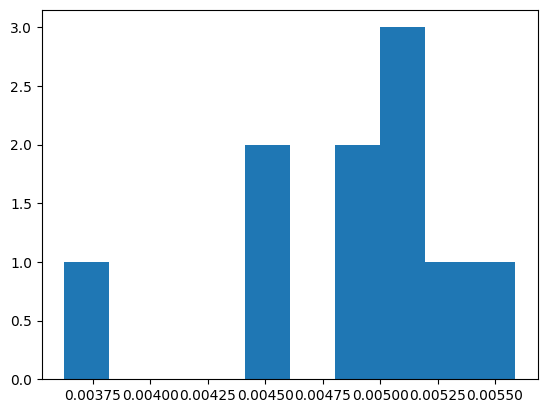

In [ ]:
plt.hist(all_rand_scores)
plt.show()

# search by actvs

## actv data

In [ ]:
dataset = load_dataset("Skylion007/openwebtext", split="train", streaming=True)

The repository for Skylion007/openwebtext contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/Skylion007/openwebtext.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


In [ ]:
dataset

IterableDataset({
    features: ['text'],
    n_shards: 21
})

In [ ]:
# Function to get next batch
def get_next_batch(dataset_iter, batch_size=100):
    batch = []
    for _ in range(batch_size):
        try:
            sample = next(dataset_iter)
            batch.append(sample['text'])
        except StopIteration:
            break
    return batch

# Get a batch of 100 samples
dataset_iter = iter(dataset)
batch = get_next_batch(dataset_iter)

# Tokenize the batch
batch_tokens = model.tokenizer(batch, return_tensors="pt", padding=True, truncation=True, max_length=300)
batch_tokens = batch_tokens['input_ids']

## get LLM actvs

In [ ]:
h_store = torch.zeros((batch_tokens.shape[0], batch_tokens.shape[1], model.cfg.d_model), device=model.cfg.device)
h_store.shape

torch.Size([100, 300, 768])

In [ ]:
from torch import nn, Tensor
from jaxtyping import Float, Int
from typing import Optional, Callable, Union, List, Tuple

def store_h_hook(
    pattern: Float[Tensor, "batch seqlen d_model"],
    hook
):
    h_store[:] = pattern  # this works b/c changes values, not replaces entire thing

In [ ]:
model.run_with_hooks(
    batch_tokens,
    return_type = None,
    fwd_hooks=[
        (layer_name, store_h_hook),
    ]
)

OutOfMemoryError: CUDA out of memory. Tried to allocate 412.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 361.06 MiB is free. Process 43447 has 14.39 GiB memory in use. Of the allocated memory 13.87 GiB is allocated by PyTorch, and 408.85 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

## get SAE actvs

In [ ]:
sae.eval()
with torch.no_grad():
    feature_acts = sae.encode(h_store)

OutOfMemoryError: CUDA out of memory. Tried to allocate 2.75 GiB. GPU 0 has a total capacity of 14.75 GiB of which 465.06 MiB is free. Process 43447 has 14.29 GiB memory in use. Of the allocated memory 13.77 GiB is allocated by PyTorch, and 407.85 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

## top actvs of specific inputs

In [ ]:
# Get the top k largest activations for feature neurons, not batch seq. use , dim=-1
# if want to get highest batch, use dim=0
feat_k = 15
top_acts_values, top_acts_indices = feature_acts.topk(feat_k, dim=-1)

print(top_acts_indices.shape)
top_acts_values.shape

torch.Size([2, 1, 15])


torch.Size([2, 1, 15])

In [ ]:
top_acts_indices

tensor([[[11746, 11533,  4078, 13997,  7662,   818, 17719,  6955,  2472,  8923,
           5279, 10471, 11216,  7477, 10236]],

        [[11746, 11533,  4078, 13997,  7662,   818, 17719,  6955,  8923,  7477,
          11216,  3355,  7702,  5279, 15113]]], device='cuda:0')

In [ ]:
def highest_activating_tokens(
    feature_acts,
    feature_idx: int,
    k: int = 10,  # num batch_seq samples
    batch_tokens=None
) -> Tuple[Int[Tensor, "k 2"], Float[Tensor, "k"]]:
    '''
    Returns the indices & values for the highest-activating tokens in the given batch of data.
    '''
    batch_size, seq_len = batch_tokens.shape

    # Get the top k largest activations for only targeted feature
    # need to flatten (batch,seq) into batch*seq first because it's ANY batch_seq, even if in same batch or same pos
    flattened_feature_acts = feature_acts[:, :, feature_idx].reshape(-1)

    top_acts_values, top_acts_indices = flattened_feature_acts.topk(k)
    # top_acts_values should be 1D
    # top_acts_indices should be also be 1D. Now, turn it back to 2D
    # Convert the indices into (batch, seq) indices
    top_acts_batch = top_acts_indices // seq_len
    top_acts_seq = top_acts_indices % seq_len

    return torch.stack([top_acts_batch, top_acts_seq], dim=-1), top_acts_values

In [ ]:
from rich import print as rprint
def display_top_sequences(top_acts_indices, top_acts_values, batch_tokens):
    s = ""
    for (batch_idx, seq_idx), value in zip(top_acts_indices, top_acts_values):
        # s += f'{batch_idx}\n'
        s += f'batchID: {batch_idx}, '
        # Get the sequence as a string (with some padding on either side of our sequence)
        seq_start = max(seq_idx - 5, 0)
        # seq_end = min(seq_idx + 5, all_tokens.shape[1])
        seq_end = min(seq_idx + 5, batch_tokens.shape[1])
        seq = ""
        # Loop over the sequence, adding each token to the string (highlighting the token with the large activations)
        for i in range(seq_start, seq_end):
            # new_str_token = model.to_single_str_token(tokens[batch_idx, i].item()).replace("\n", "\\n").replace("<|BOS|>", "|BOS|")
            new_str_token = model.to_single_str_token(batch_tokens[batch_idx, i].item()).replace("\n", "\\n").replace("<|BOS|>", "|BOS|")
            if i == seq_idx:
                new_str_token = f"[bold u dark_orange]{new_str_token}[/]"
            seq += new_str_token
        # Print the sequence, and the activation value
        s += f'Act = {value:.2f}, Seq = "{seq}"\n'

    rprint(s)

In [ ]:
# get top samp_m tokens for all top feat_k feature neurons
samp_m = 5

for feature_idx in top_acts_indices[0, -1, :]:
    feature_idx = feature_idx.item()
    print('Feature: ', feature_idx)
    ds_top_acts_indices, ds_top_acts_values = highest_activating_tokens(feature_acts, feature_idx, 1, batch_tokens=batch_tokens)
    display_top_sequences(ds_top_acts_indices, ds_top_acts_values, batch_tokens=batch_tokens)

Feature:  11746


batchID: 0, Act = 506.78, Seq = "one"

Feature:  11533


batchID: 0, Act = 469.81, Seq = "one"

Feature:  4078


batchID: 0, Act = 454.50, Seq = "one"

Feature:  13997


batchID: 0, Act = 431.10, Seq = "one"

Feature:  7662


batchID: 0, Act = 416.27, Seq = "one"

Feature:  818


batchID: 0, Act = 355.47, Seq = "one"

Feature:  17719


batchID: 0, Act = 340.20, Seq = "one"

Feature:  6955


batchID: 0, Act = 127.40, Seq = "one"

Feature:  2472


batchID: 0, Act = 2.30, Seq = "one"

Feature:  8923


batchID: 1, Act = 2.57, Seq = "two"

Feature:  5279


batchID: 0, Act = 1.94, Seq = "one"

Feature:  10471


batchID: 0, Act = 1.90, Seq = "one"

Feature:  11216


batchID: 1, Act = 1.65, Seq = "two"

Feature:  7477


batchID: 1, Act = 2.17, Seq = "two"

Feature:  10236


batchID: 0, Act = 0.87, Seq = "one"

In [ ]:
# get top samp_m tokens for all top feat_k feature neurons
samp_m = 5

for feature_idx in one_indices[:, 1]:
    feature_idx = feature_idx.item()
    print('Feature: ', feature_idx)
    ds_top_acts_indices, ds_top_acts_values = highest_activating_tokens(one_feature_acts, feature_idx, 1, batch_tokens=batch_tokens)
    display_top_sequences(ds_top_acts_indices, ds_top_acts_values, batch_tokens=batch_tokens)

Feature:  818


batchID: 0, Act = 355.47, Seq = "blue"

Feature:  2472


batchID: 0, Act = 2.30, Seq = "blue"

Feature:  3355


batchID: 0, Act = 0.81, Seq = "blue"

Feature:  4078


batchID: 0, Act = 454.50, Seq = "blue"

Feature:  5279


batchID: 0, Act = 1.94, Seq = "blue"

Feature:  6054


batchID: 0, Act = 0.32, Seq = "blue"

Feature:  6955


batchID: 0, Act = 127.40, Seq = "blue"

Feature:  7477


batchID: 0, Act = 1.02, Seq = "blue"

Feature:  7662


batchID: 0, Act = 416.27, Seq = "blue"

Feature:  8923


batchID: 0, Act = 2.18, Seq = "blue"

Feature:  9275


batchID: 0, Act = 0.41, Seq = "blue"

Feature:  10236


batchID: 0, Act = 0.87, Seq = "blue"

Feature:  10471


batchID: 0, Act = 1.90, Seq = "blue"

Feature:  11216


batchID: 0, Act = 1.07, Seq = "blue"

Feature:  11533


batchID: 0, Act = 469.81, Seq = "blue"

Feature:  11746


batchID: 0, Act = 506.78, Seq = "blue"

Feature:  13997


batchID: 0, Act = 431.10, Seq = "blue"

Feature:  14831


batchID: 0, Act = 0.25, Seq = "blue"

Feature:  15113


batchID: 0, Act = 0.00, Seq = "blue"

Feature:  15727


batchID: 0, Act = 0.20, Seq = "blue"

Feature:  17719


batchID: 0, Act = 340.20, Seq = "blue"

Feature:  19817


batchID: 0, Act = 0.07, Seq = "blue"

Feature:  20920


batchID: 0, Act = 0.00, Seq = "blue"

In [ ]:
# get top samp_m tokens for all top feat_k feature neurons
samp_m = 5

batch = ["one"]
input_tokens = model.tokenizer(batch, return_tensors="pt", padding=True, truncation=True, max_length=300)
batch_tokens = input_tokens['input_ids']

for feature_idx in one_indices[:, 1]:
    feature_idx = feature_idx.item()
    print('Feature: ', feature_idx)
    ds_top_acts_indices, ds_top_acts_values = highest_activating_tokens(one_feature_acts, feature_idx, 1, batch_tokens=batch_tokens)
    display_top_sequences(ds_top_acts_indices, ds_top_acts_values, batch_tokens=batch_tokens)

Feature:  818


batchID: 0, Act = 355.47, Seq = "one"

Feature:  4078


batchID: 0, Act = 454.50, Seq = "one"

Feature:  6955


batchID: 0, Act = 127.40, Seq = "one"

Feature:  7662


batchID: 0, Act = 416.27, Seq = "one"

Feature:  11533


batchID: 0, Act = 469.81, Seq = "one"

Feature:  11746


batchID: 0, Act = 506.78, Seq = "one"

Feature:  13997


batchID: 0, Act = 431.10, Seq = "one"

Feature:  17719


batchID: 0, Act = 340.20, Seq = "one"